In [1]:
# imports for entire notebook

import requests
import json

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae

import os

import numpy.random

import constants #git-ignored file containing API keys, etc

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [3]:
# very settings!

sns.set()

plt.rcParams['figure.figsize'] = (15,8)
plt.rcParams['figure.dpi'] = 300

In [4]:
# get the Cushing spot WTI price (daily) from the US Energy Information Administration (EIA) API:

request_price = requests.get('http://api.eia.gov/series/?api_key={}&series_id=PET.RWTC.D'.format(constants.eia_api_key))

request_price

<Response [200]>

In [5]:
# extract and create a dataframe from the daily data:

response_price = json.loads(request_price.text)

daily = response_price.get('series')[0].get('data')

dates = [i[0] for i in daily]
price = [i[1] for i in daily]

dailydf = pd.DataFrame({'price': price}, index=pd.to_datetime(dates))


# resample so that all days are covered, and any missing days
# (weekends, for instance) are forward-filled from the previous value 

dailydf = dailydf.resample('d').ffill()


# create a feature from the trailing 90-day average price:

dailydf['t90d_mean'] = dailydf['price'].rolling(90).mean()


# create the target: an average WTI spot price for the upcoming 30 days:

indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=30)
dailydf['f30d_mean'] = dailydf['price'].rolling(window=indexer).mean()

dailydf

price  t90d_mean  f30d_mean
1986-01-02  25.56        NaN  23.127333
1986-01-03  26.00        NaN  22.907000
1986-01-04  26.00        NaN  22.672000
1986-01-05  26.00        NaN  22.386000
1986-01-06  26.53        NaN  22.038667
...           ...        ...        ...
2021-11-12  80.87  75.336333        NaN
2021-11-13  80.87  75.475333        NaN
2021-11-14  80.87  75.624556        NaN
2021-11-15  80.85  75.784000        NaN
2021-11-16  80.76  75.955111        NaN

[13103 rows x 3 columns]

<AxesSubplot:>

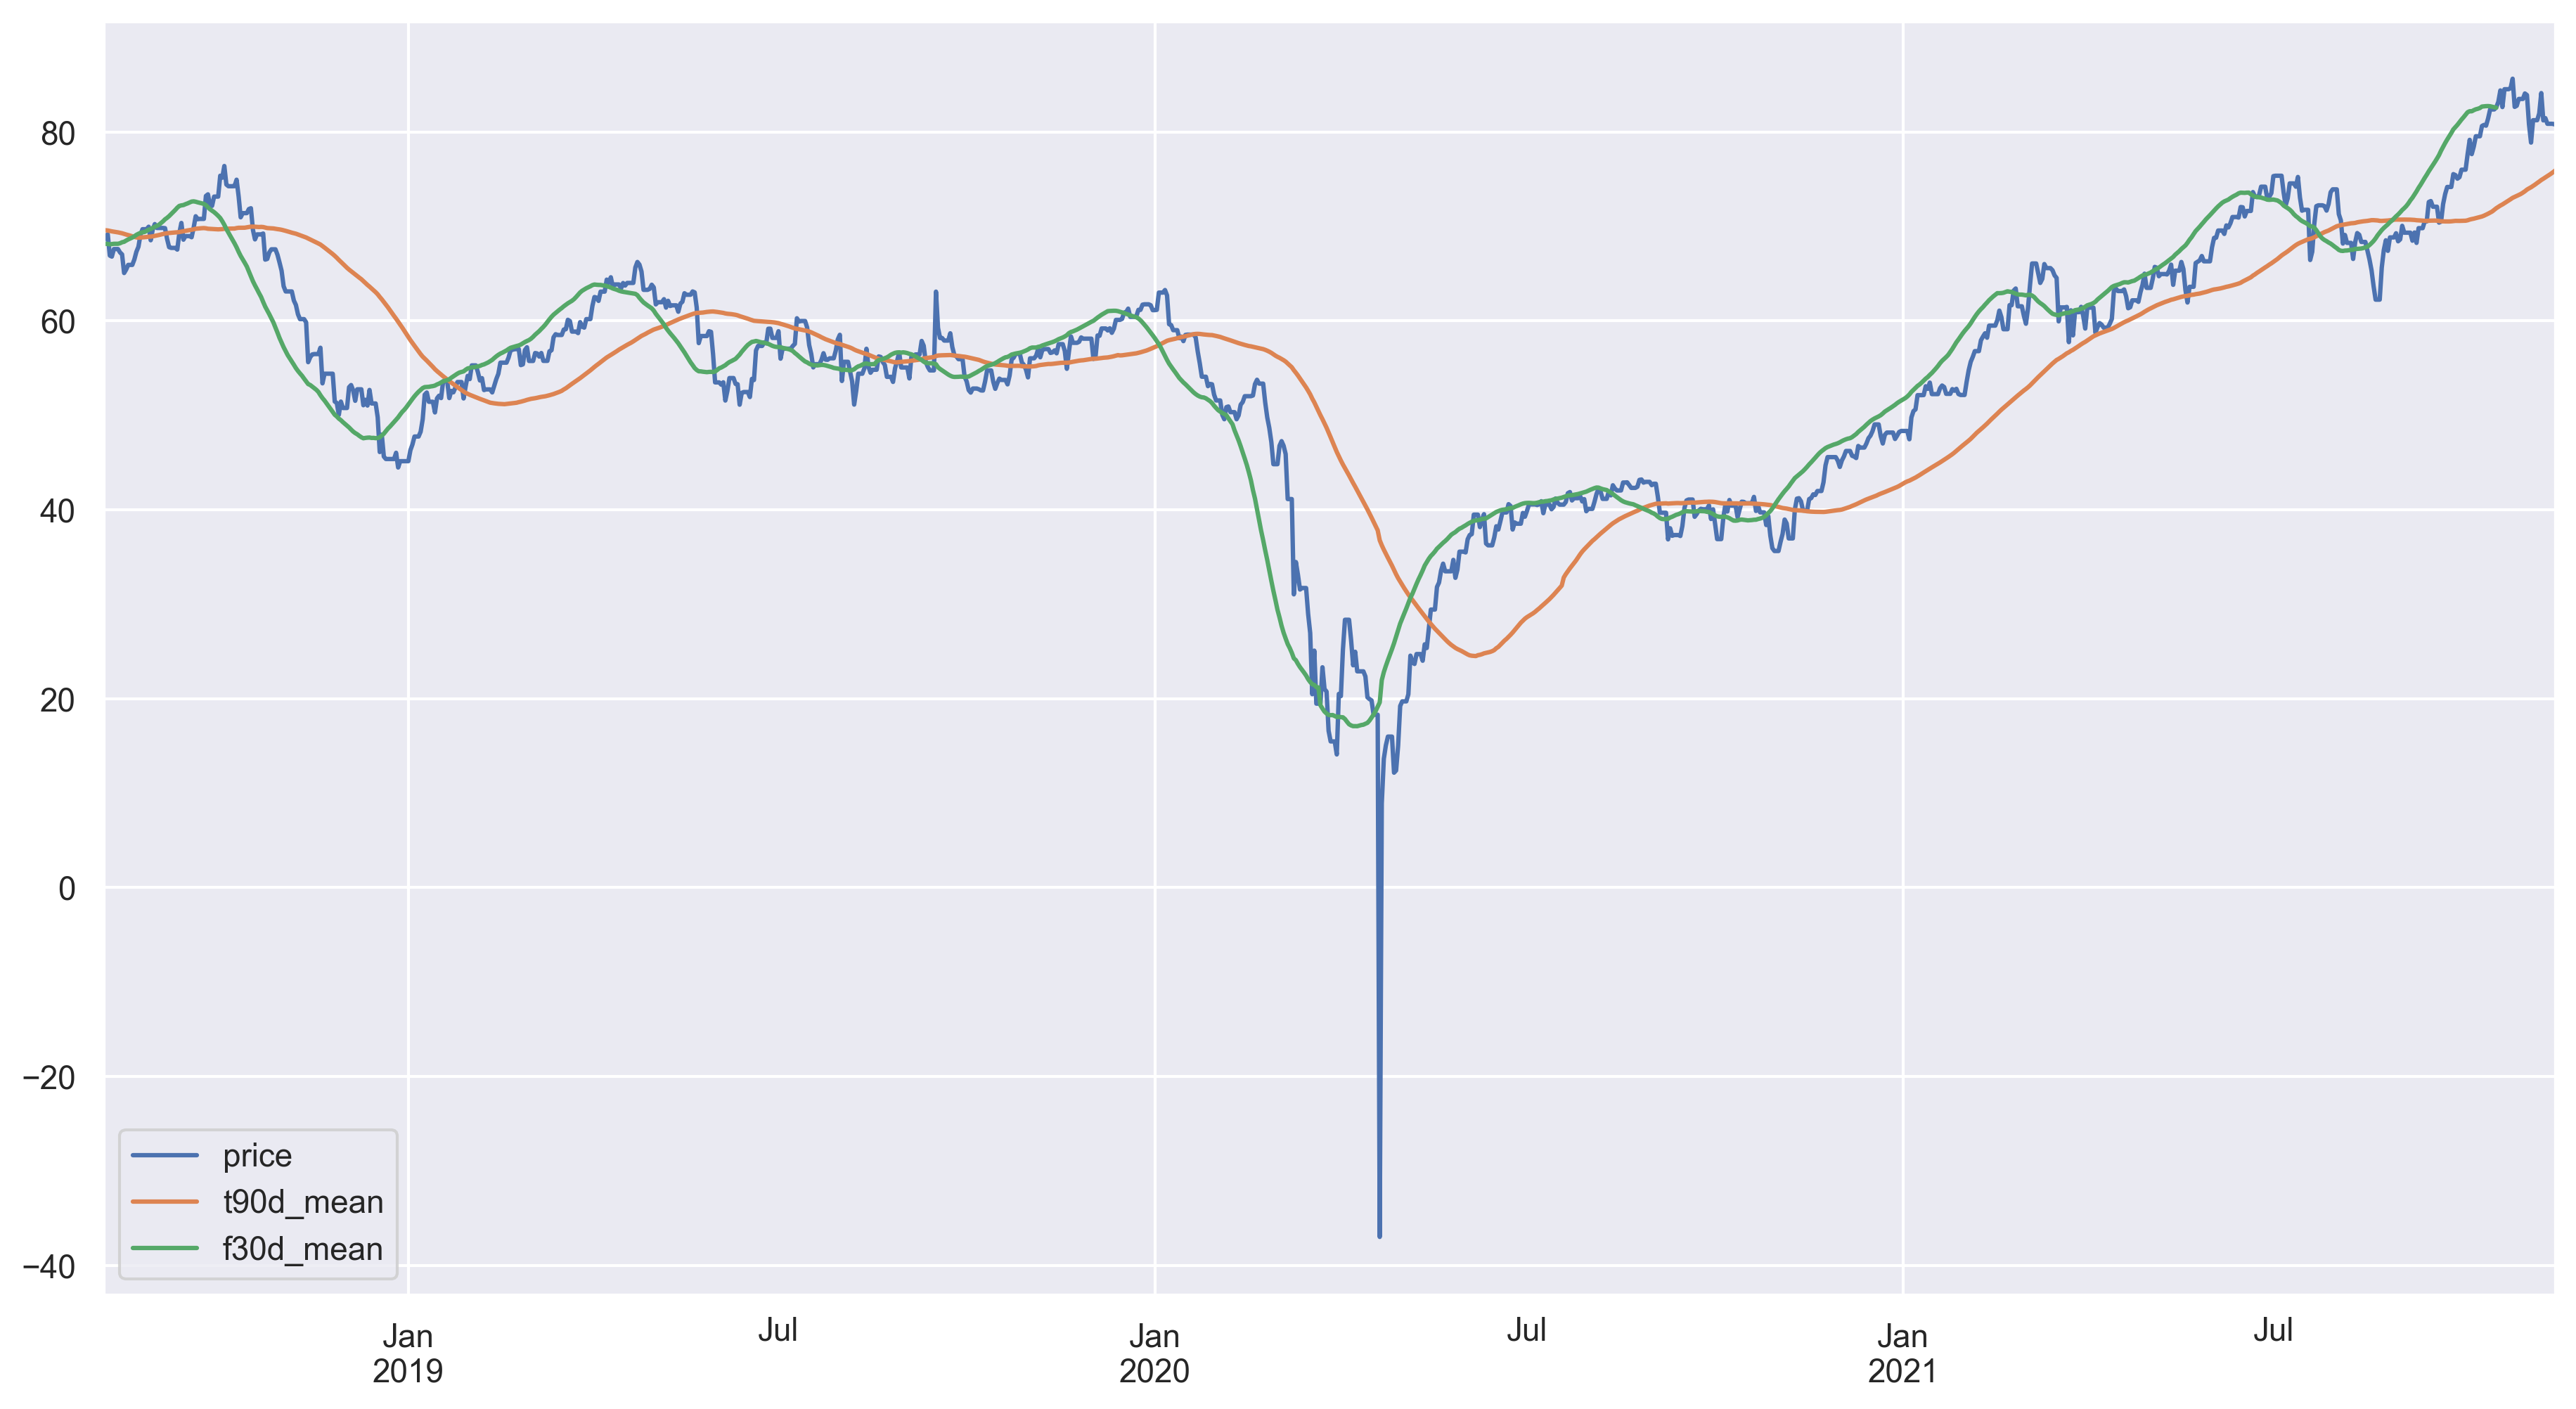

In [6]:
# quick view of the most recent daily data:

dailydf[-1200:].plot()

In [7]:
# get weekly EIA data for US oil storage and US oil production:

request_weekly = requests.get('http://api.eia.gov/series/?api_key={}&series_id=PET.WCRSTUS1.W;PET.WCRFPUS2.W'.format(
    constants.eia_api_key))

request_weekly

<Response [200]>

In [8]:
# extract and create a dataframe from the weekly storage data:

storage = json.loads(request_weekly.text).get('series')[0].get('data')

day = [i[0] for i in storage]
storage = [i[1] for i in storage]

storagedf = pd.DataFrame({'storage': storage}, index=pd.to_datetime(day))

storagedf

storage
2021-11-12  1039150
2021-11-05  1044500
2021-10-29  1046643
2021-10-22  1044998
2021-10-15  1041820
...             ...
1982-10-08   613985
1982-10-01   612419
1982-09-24   612419
1982-08-27   608741
1982-08-20   609219

[2042 rows x 1 columns]

In [11]:
# extract and create a dataframe from the weekly production data:

usprod = json.loads(request_weekly.text).get('series')[1].get('data')

day = [i[0] for i in usprod]
prod = [i[1] for i in usprod]

usproddf = pd.DataFrame({'US Production': prod}, index=pd.to_datetime(day))

usproddf

US Production
2021-11-12          11400
2021-11-05          11500
2021-10-29          11500
2021-10-22          11300
2021-10-15          11300
...                   ...
1983-02-04           8660
1983-01-28           8634
1983-01-21           8634
1983-01-14           8634
1983-01-07           8634

[2025 rows x 1 columns]

In [12]:
# merge the two weekly dataframe (storage & production),
# resample daily with forward-fill for 1:1 merging with
# daily spot rate data:

weeklydf = usproddf.merge(storagedf, left_index=True, right_index=True)
weeklydf = weeklydf.resample('d').ffill()
weeklydf

US Production  storage
1983-01-07           8634   621519
1983-01-08           8634   621519
1983-01-09           8634   621519
1983-01-10           8634   621519
1983-01-11           8634   621519
...                   ...      ...
2021-11-08          11500  1044500
2021-11-09          11500  1044500
2021-11-10          11500  1044500
2021-11-11          11500  1044500
2021-11-12          11400  1039150

[14190 rows x 2 columns]

In [13]:
# get monthly US GDP data from EIA: 

mly_request = requests.get('http://api.eia.gov/series/?api_key={}&series_id=STEO.GDPQXUS.M'.format(constants.eia_api_key))
mly_request

<Response [200]>

In [14]:
# extract and create a dataframe from the monthly data:

mly_data = json.loads(mly_request.text).get('series')[0].get('data')

gdp = [i[1] for i in mly_data]

date = []
for i in range(len(mly_data)):
  month_i = str(mly_data[i][0][4:]) + '-' + str(mly_data[i][0][:4])
  date.append(month_i)

mly_df = pd.DataFrame({'gdp': gdp},
                      index=pd.to_datetime(date).to_period('M'))

mly_df = mly_df.resample('D').interpolate()

mly_df['f30d_mean_gdp'] = mly_df['gdp'].rolling(indexer).mean()
indexer365 = pd.api.indexers.FixedForwardWindowIndexer(window_size=365)
mly_df['f365d_mean_gdp'] = mly_df['gdp'].rolling(indexer365).mean()

mly_df.index = mly_df.index.to_timestamp()

mly_df

gdp  f30d_mean_gdp  f365d_mean_gdp
1990-01-01   9340.478778    9352.766670     9368.661736
1990-01-02   9341.326219    9353.614111     9368.475865
1990-01-03   9342.173660    9354.461552     9368.287526
1990-01-04   9343.021100    9355.303125     9368.096719
1990-01-05   9343.868541    9356.138830     9367.903444
...                  ...            ...             ...
2022-12-27  20512.590000            NaN             NaN
2022-12-28  20512.590000            NaN             NaN
2022-12-29  20512.590000            NaN             NaN
2022-12-30  20512.590000            NaN             NaN
2022-12-31  20512.590000            NaN             NaN

[12053 rows x 3 columns]

In [15]:
# merge the daily price data with the weekly (resampled daily)
# production & storage data:

df = dailydf.merge(weeklydf, left_index=True, right_index=True)


# merge that dataframe with the monthly (resampled daily)
# US GDP data:

df = df.merge(mly_df, left_index=True, right_index=True)
df.dropna(inplace=True)


# filter outlier rows where the oil price briefly fell below zero:

df = df.loc[df['price']>0]

df

price  t90d_mean  f30d_mean  US Production  storage           gdp  \
1990-01-01  21.84  20.387000  22.904667           7565   904134   9340.478778   
1990-01-02  22.88  20.417111  22.933000           7565   904134   9341.326219   
1990-01-03  23.81  20.460000  22.927333           7565   904134   9342.173660   
1990-01-04  23.41  20.499111  22.901667           7565   904134   9343.021100   
1990-01-05  23.07  20.534444  22.889333           7512   904076   9343.868541   
...           ...        ...        ...            ...      ...           ...   
2021-10-14  81.43  71.349222  82.745000          11400  1043945  19617.739033   
2021-10-15  82.39  71.467333  82.726333          11300  1041820  19620.178531   
2021-10-16  82.39  71.585444  82.675667          11300  1041820  19622.618029   
2021-10-17  82.39  71.762556  82.624333          11300  1041820  19625.057527   
2021-10-18  82.62  71.932556  82.570000          11300  1041820  19627.497025   

            f30d_mean_gdp  f365d_mean_gdp  
1990-01-01    9352.766670     9368.661736  
1990-01-02    9353.614111     9368.475865  
1990-01-03    9354.461552     9368.287526  
1990-01-04    9355.303125     9368.096719  
1990-01-05    9356.138830     9367.903444  
...                   ...             ...  
2021-10-14   19653.189860    20048.135191  
2021-10-15   19655.643559    20050.372550  
2021-10-16   19658.098442    20052.607767  
2021-10-17   19660.554507    20054.840844  
2021-10-18   19663.011756    20057.071779  

[11613 rows x 8 columns]

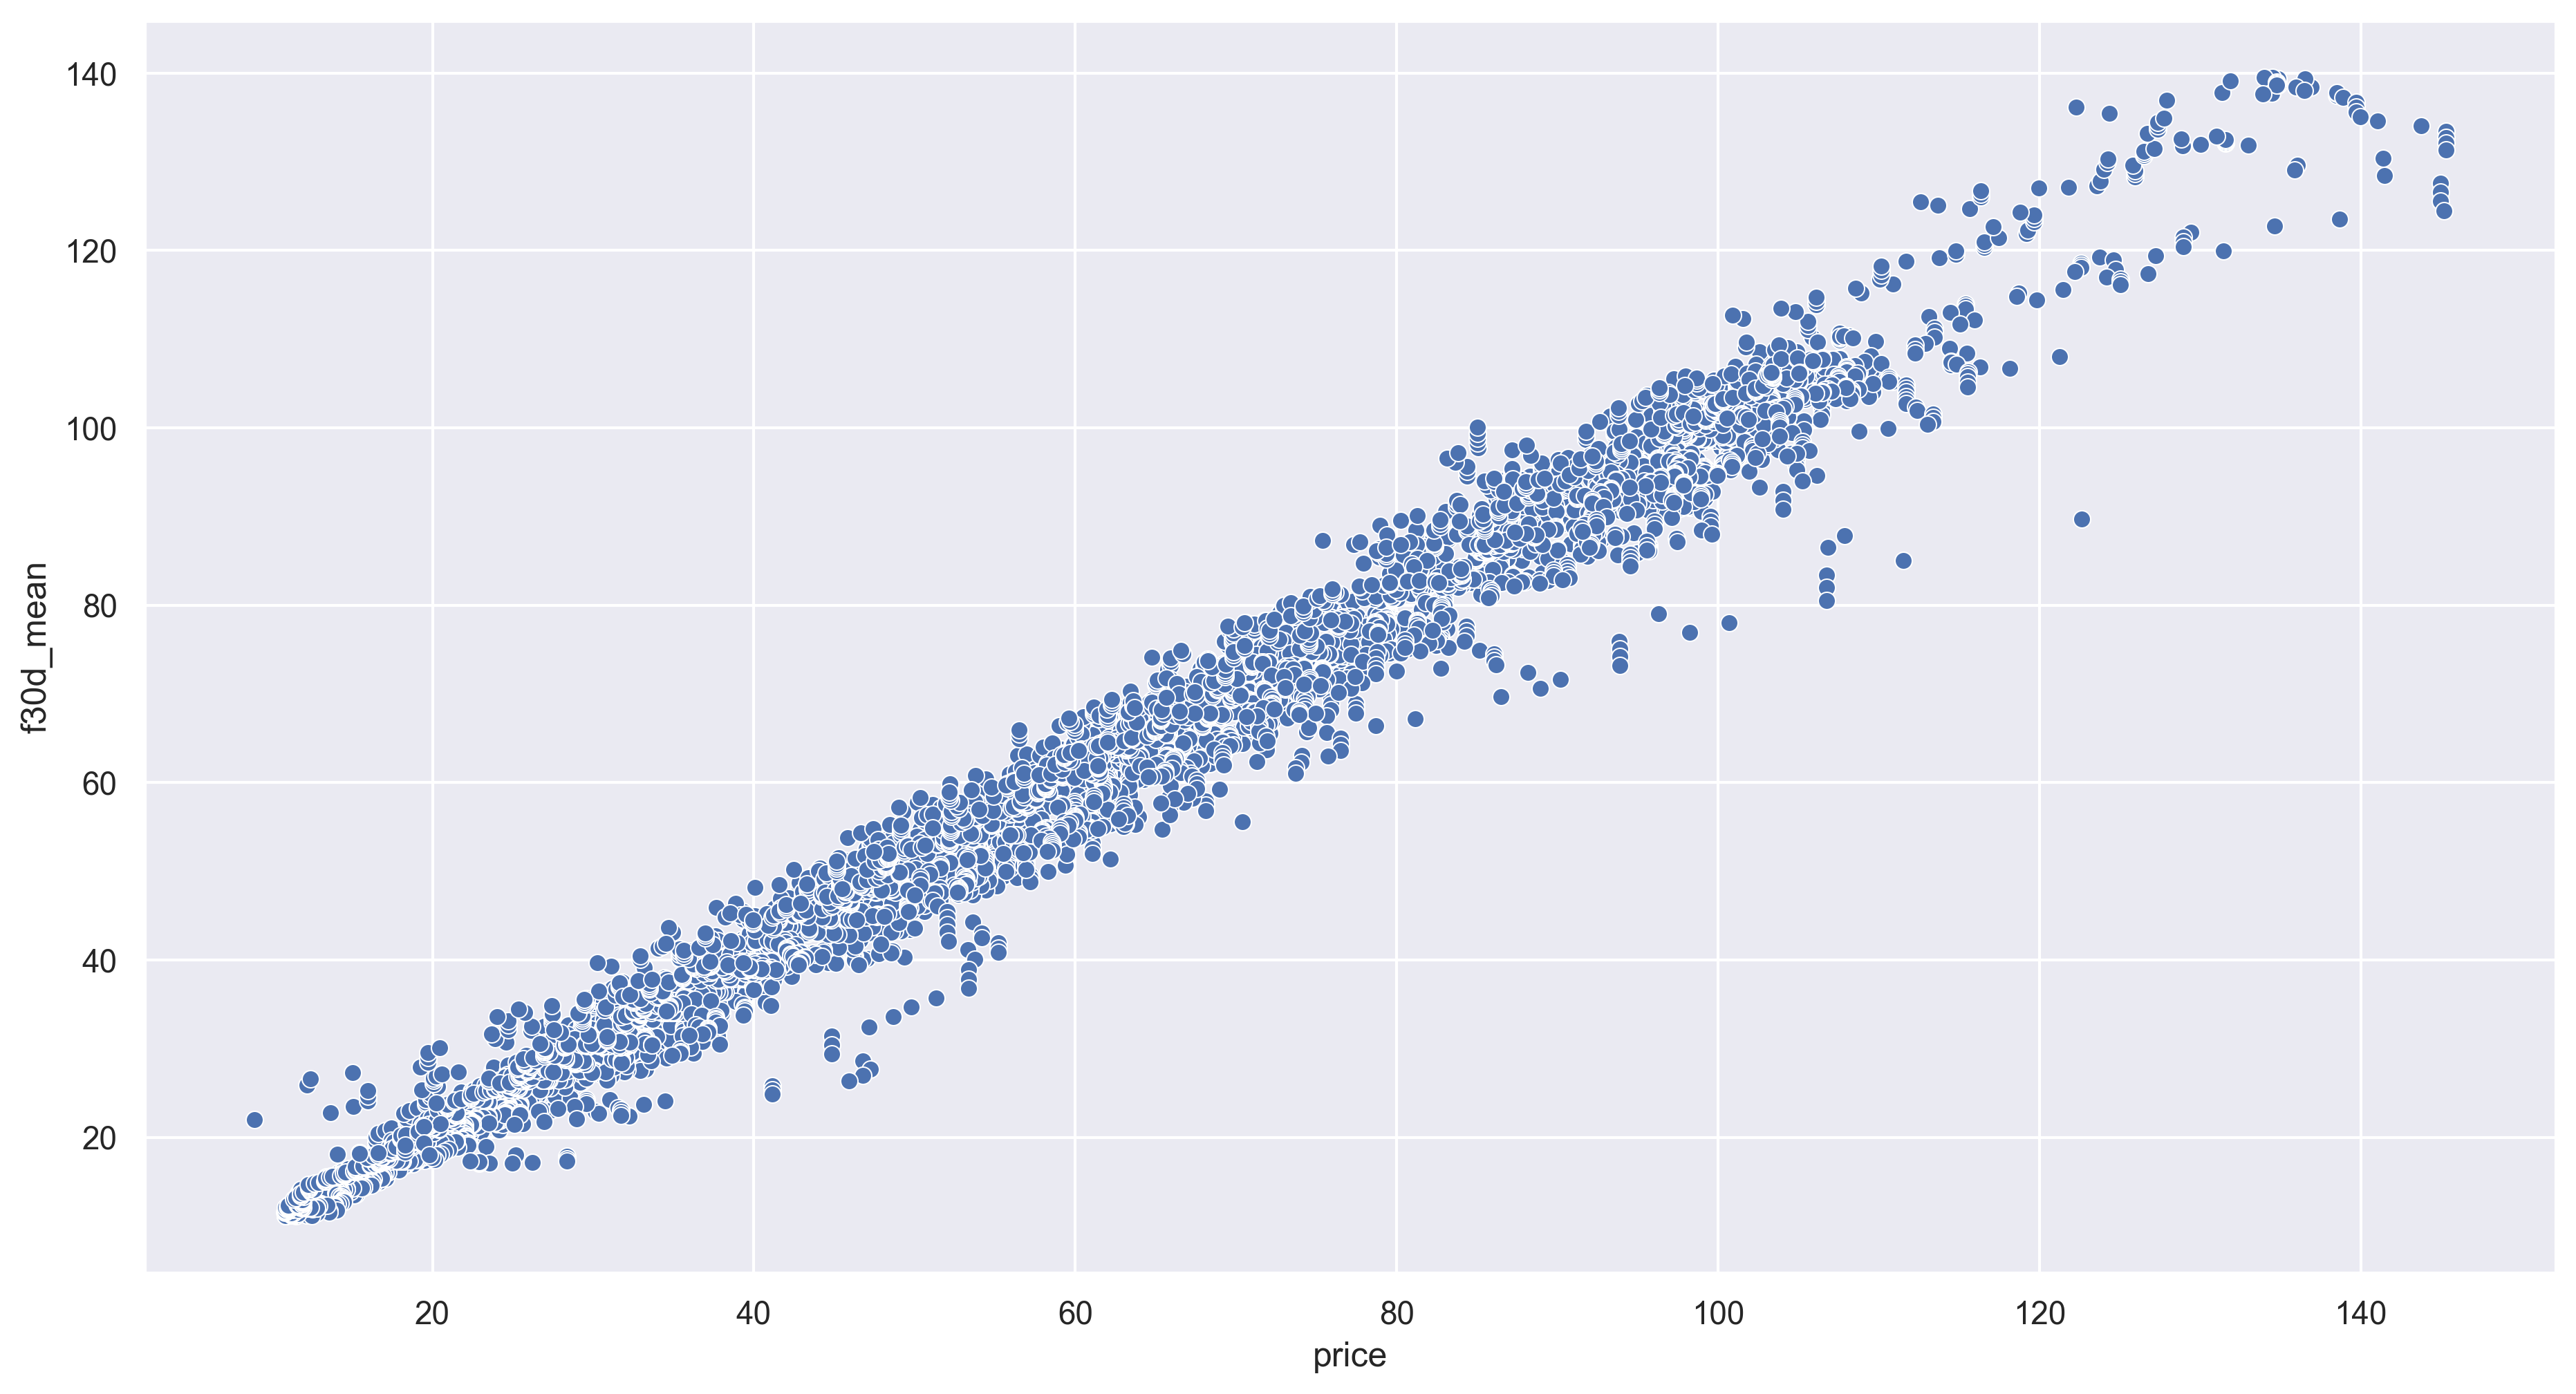

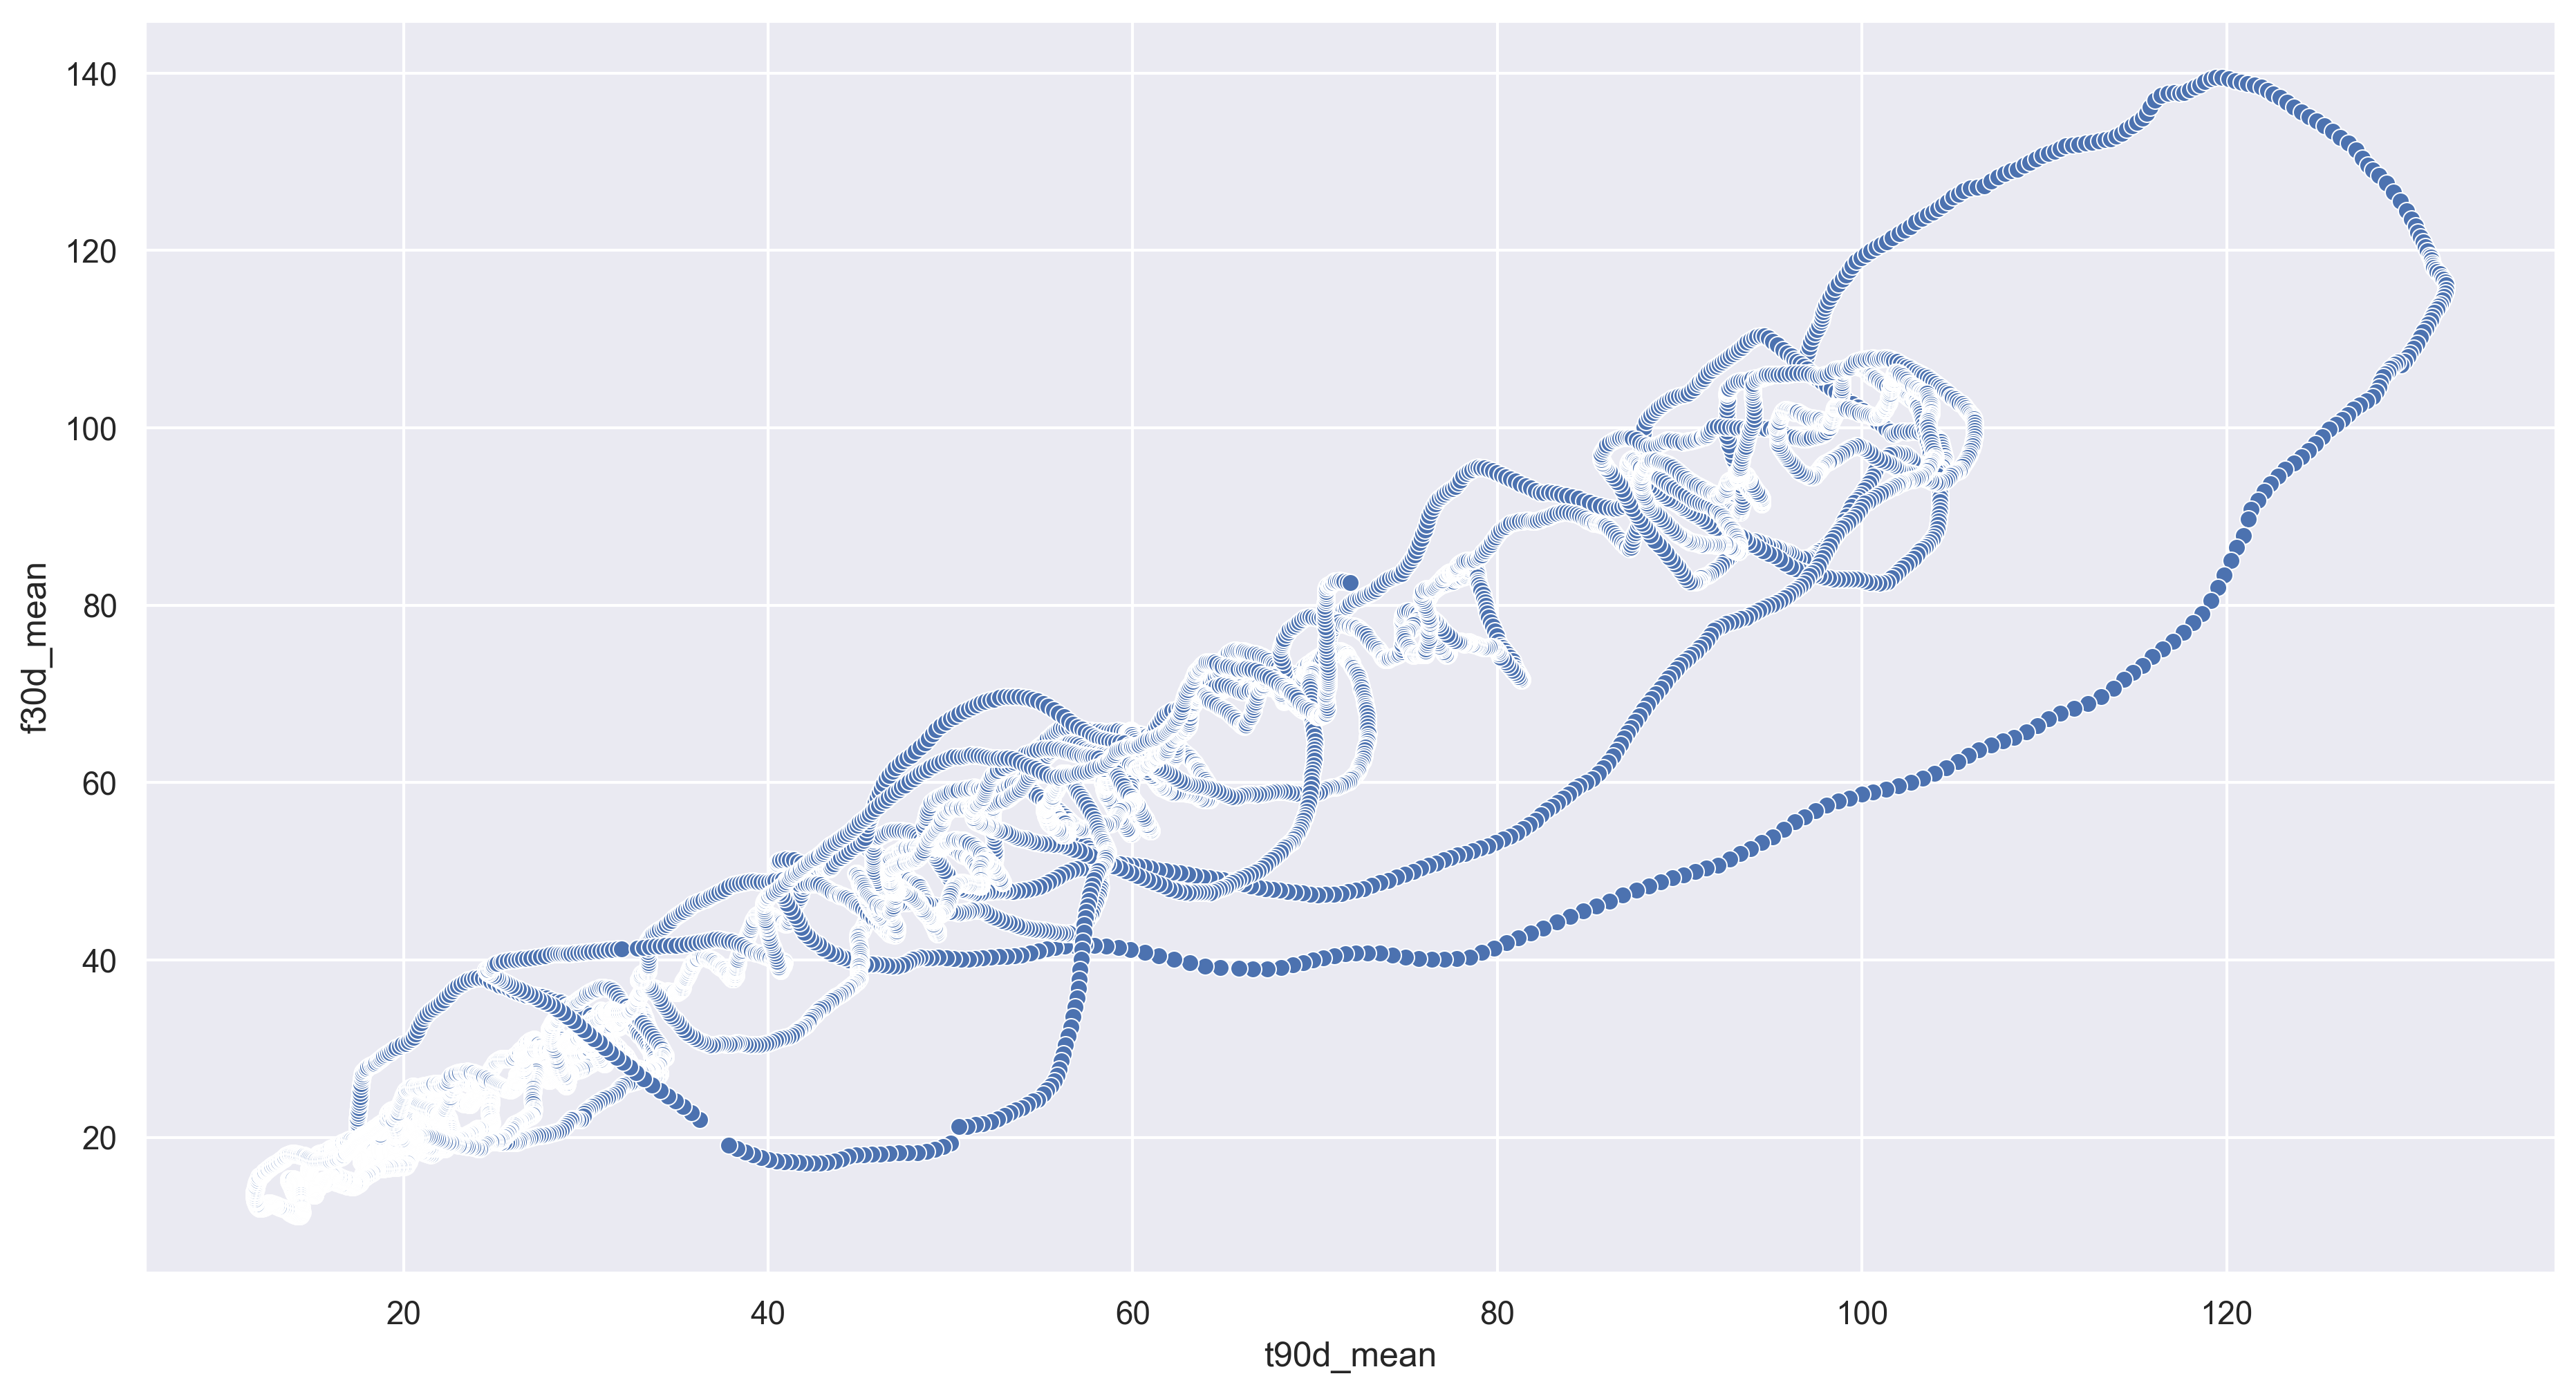

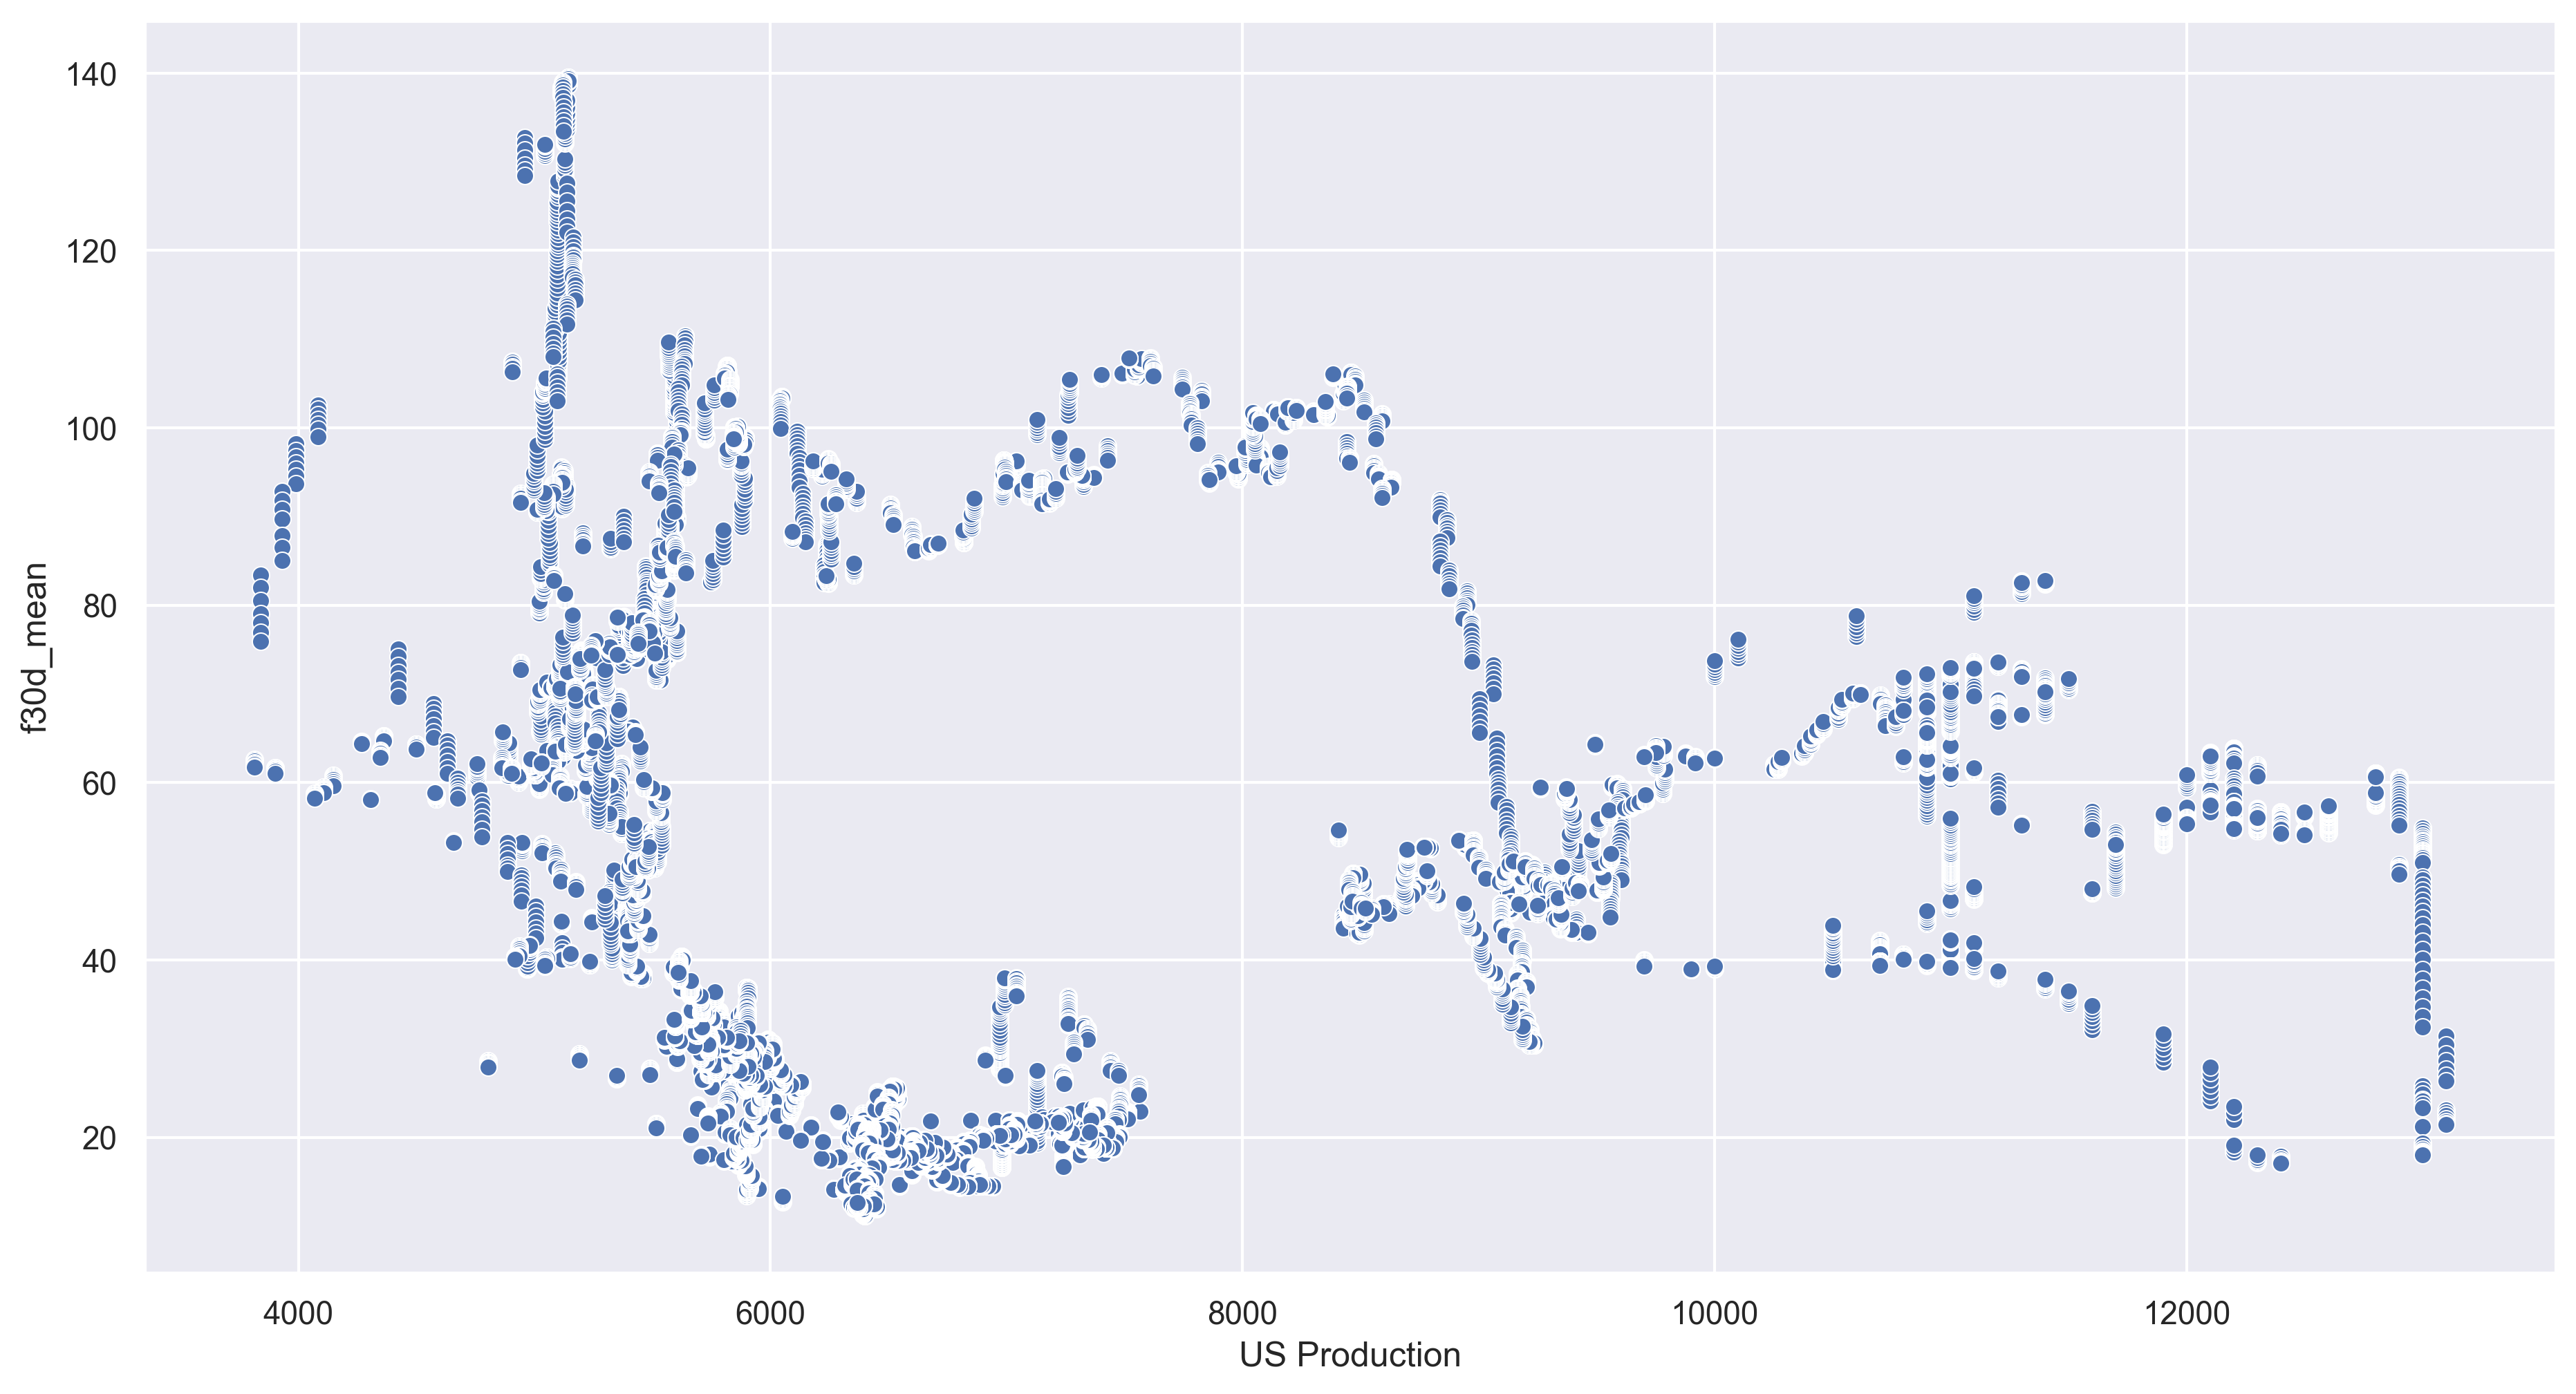

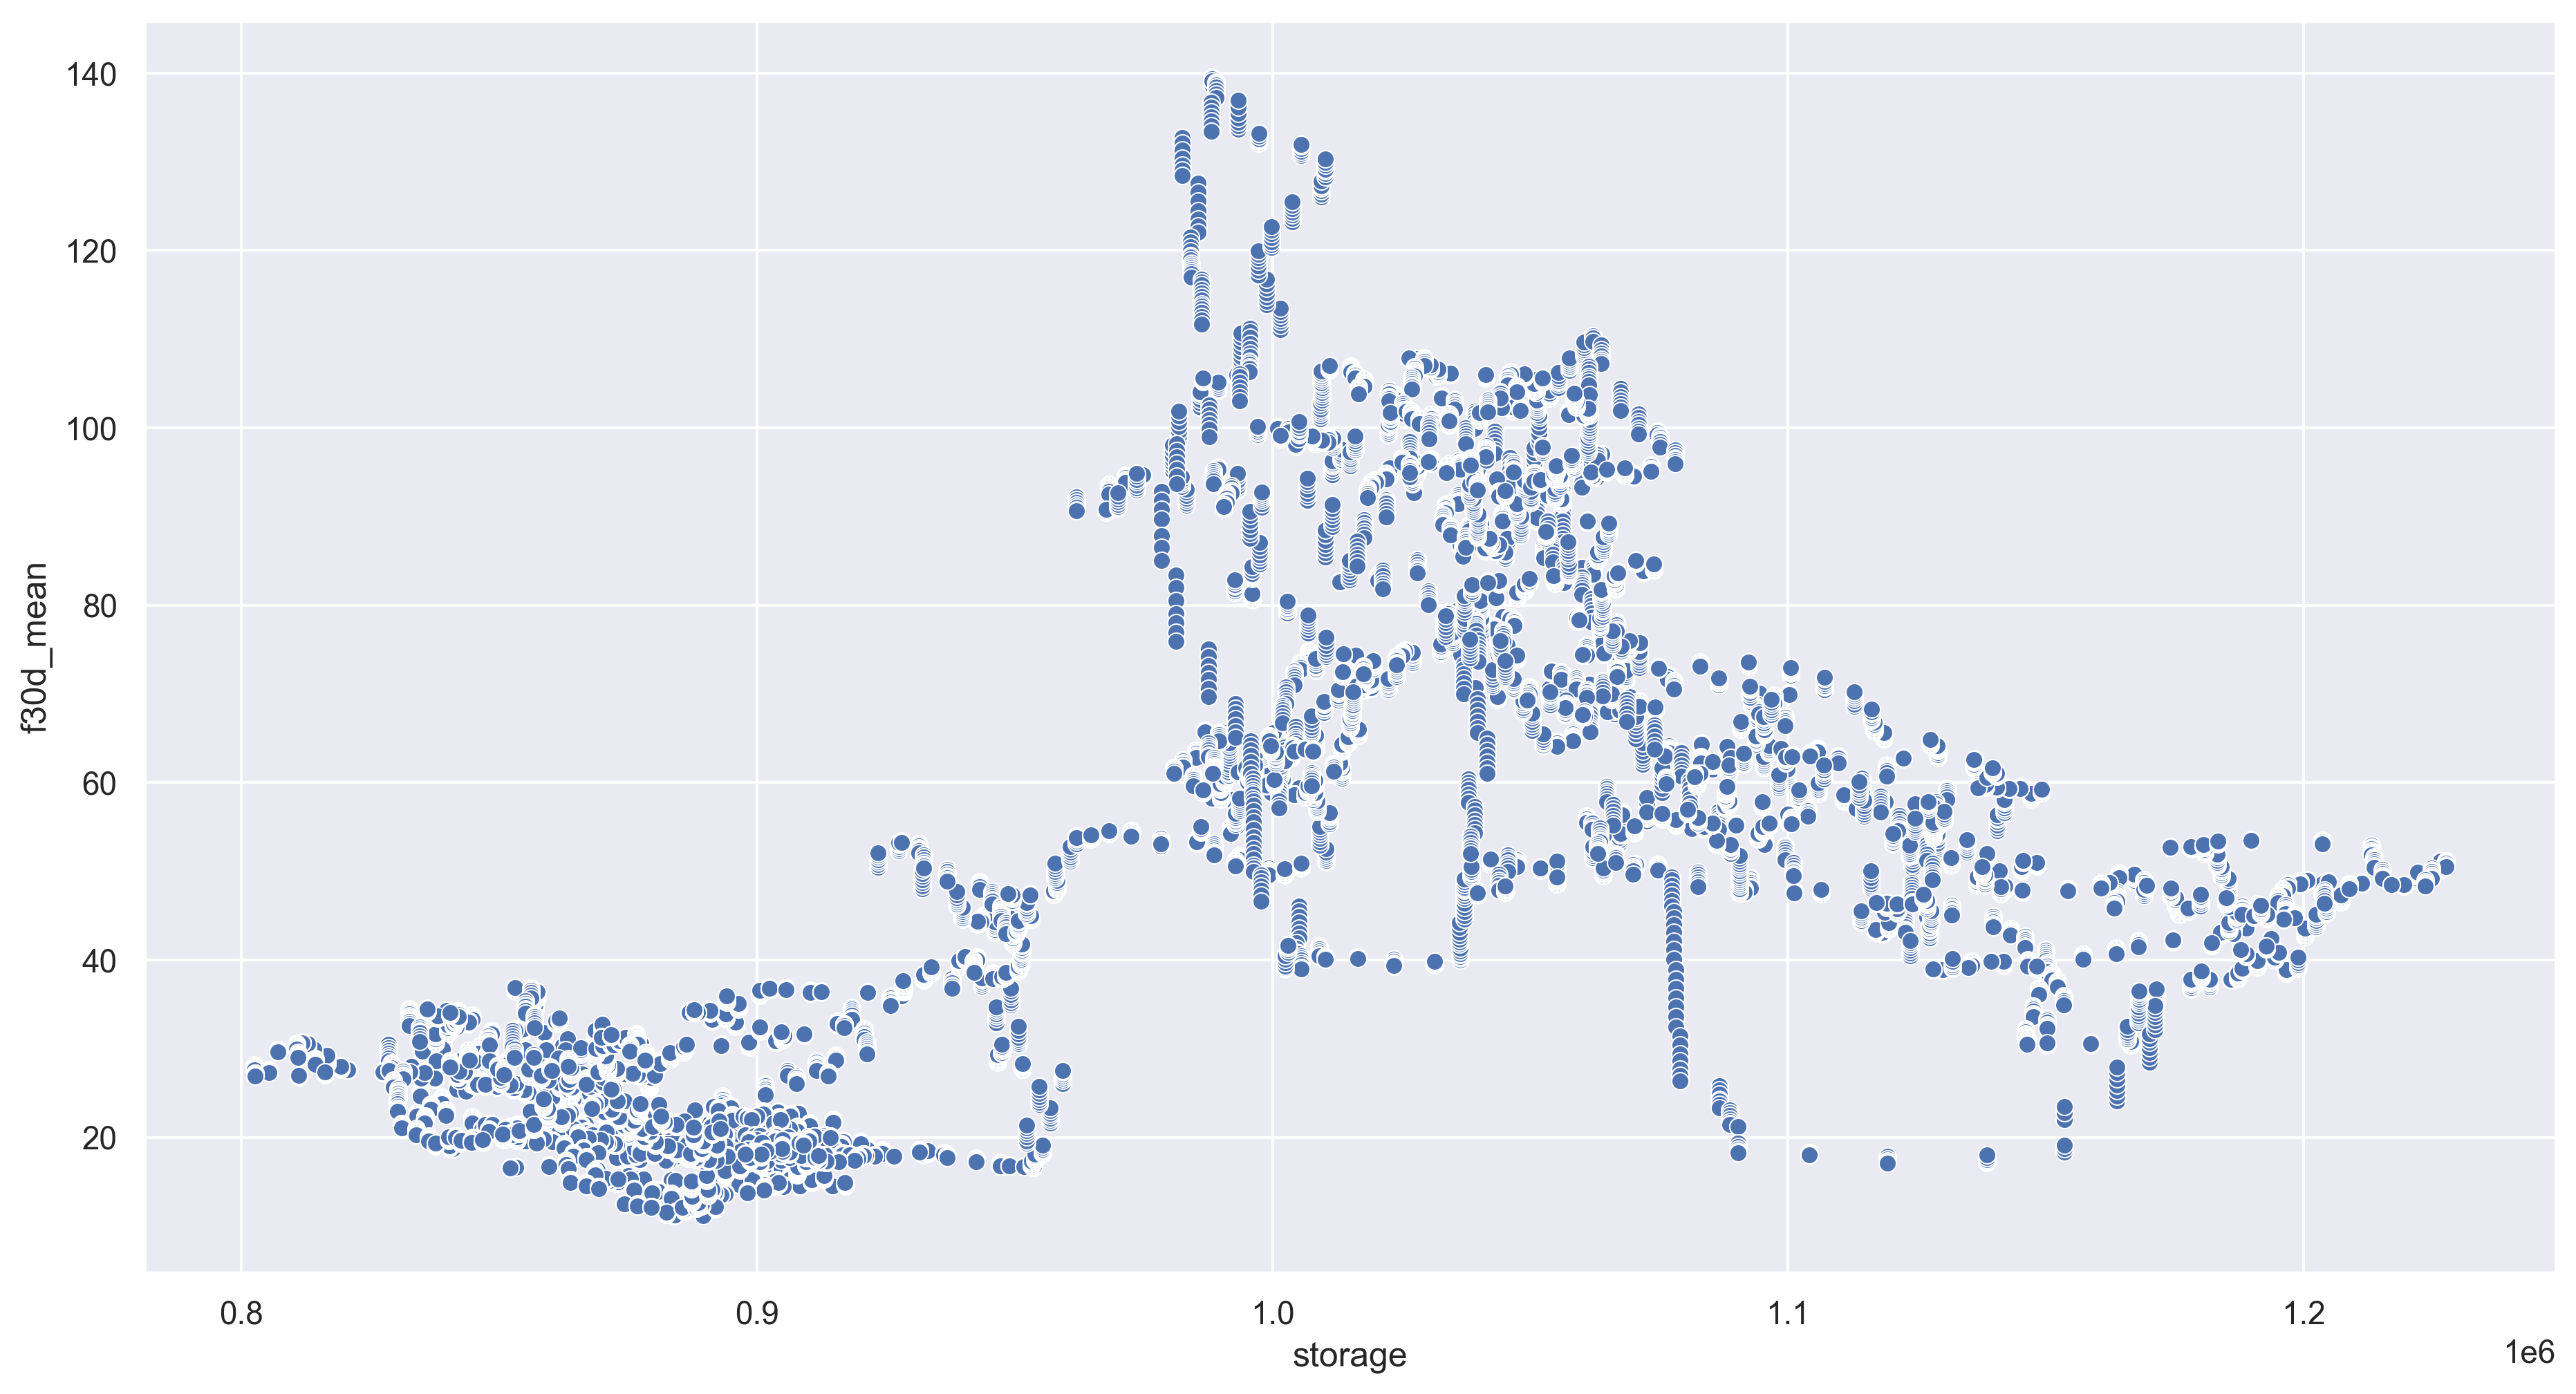

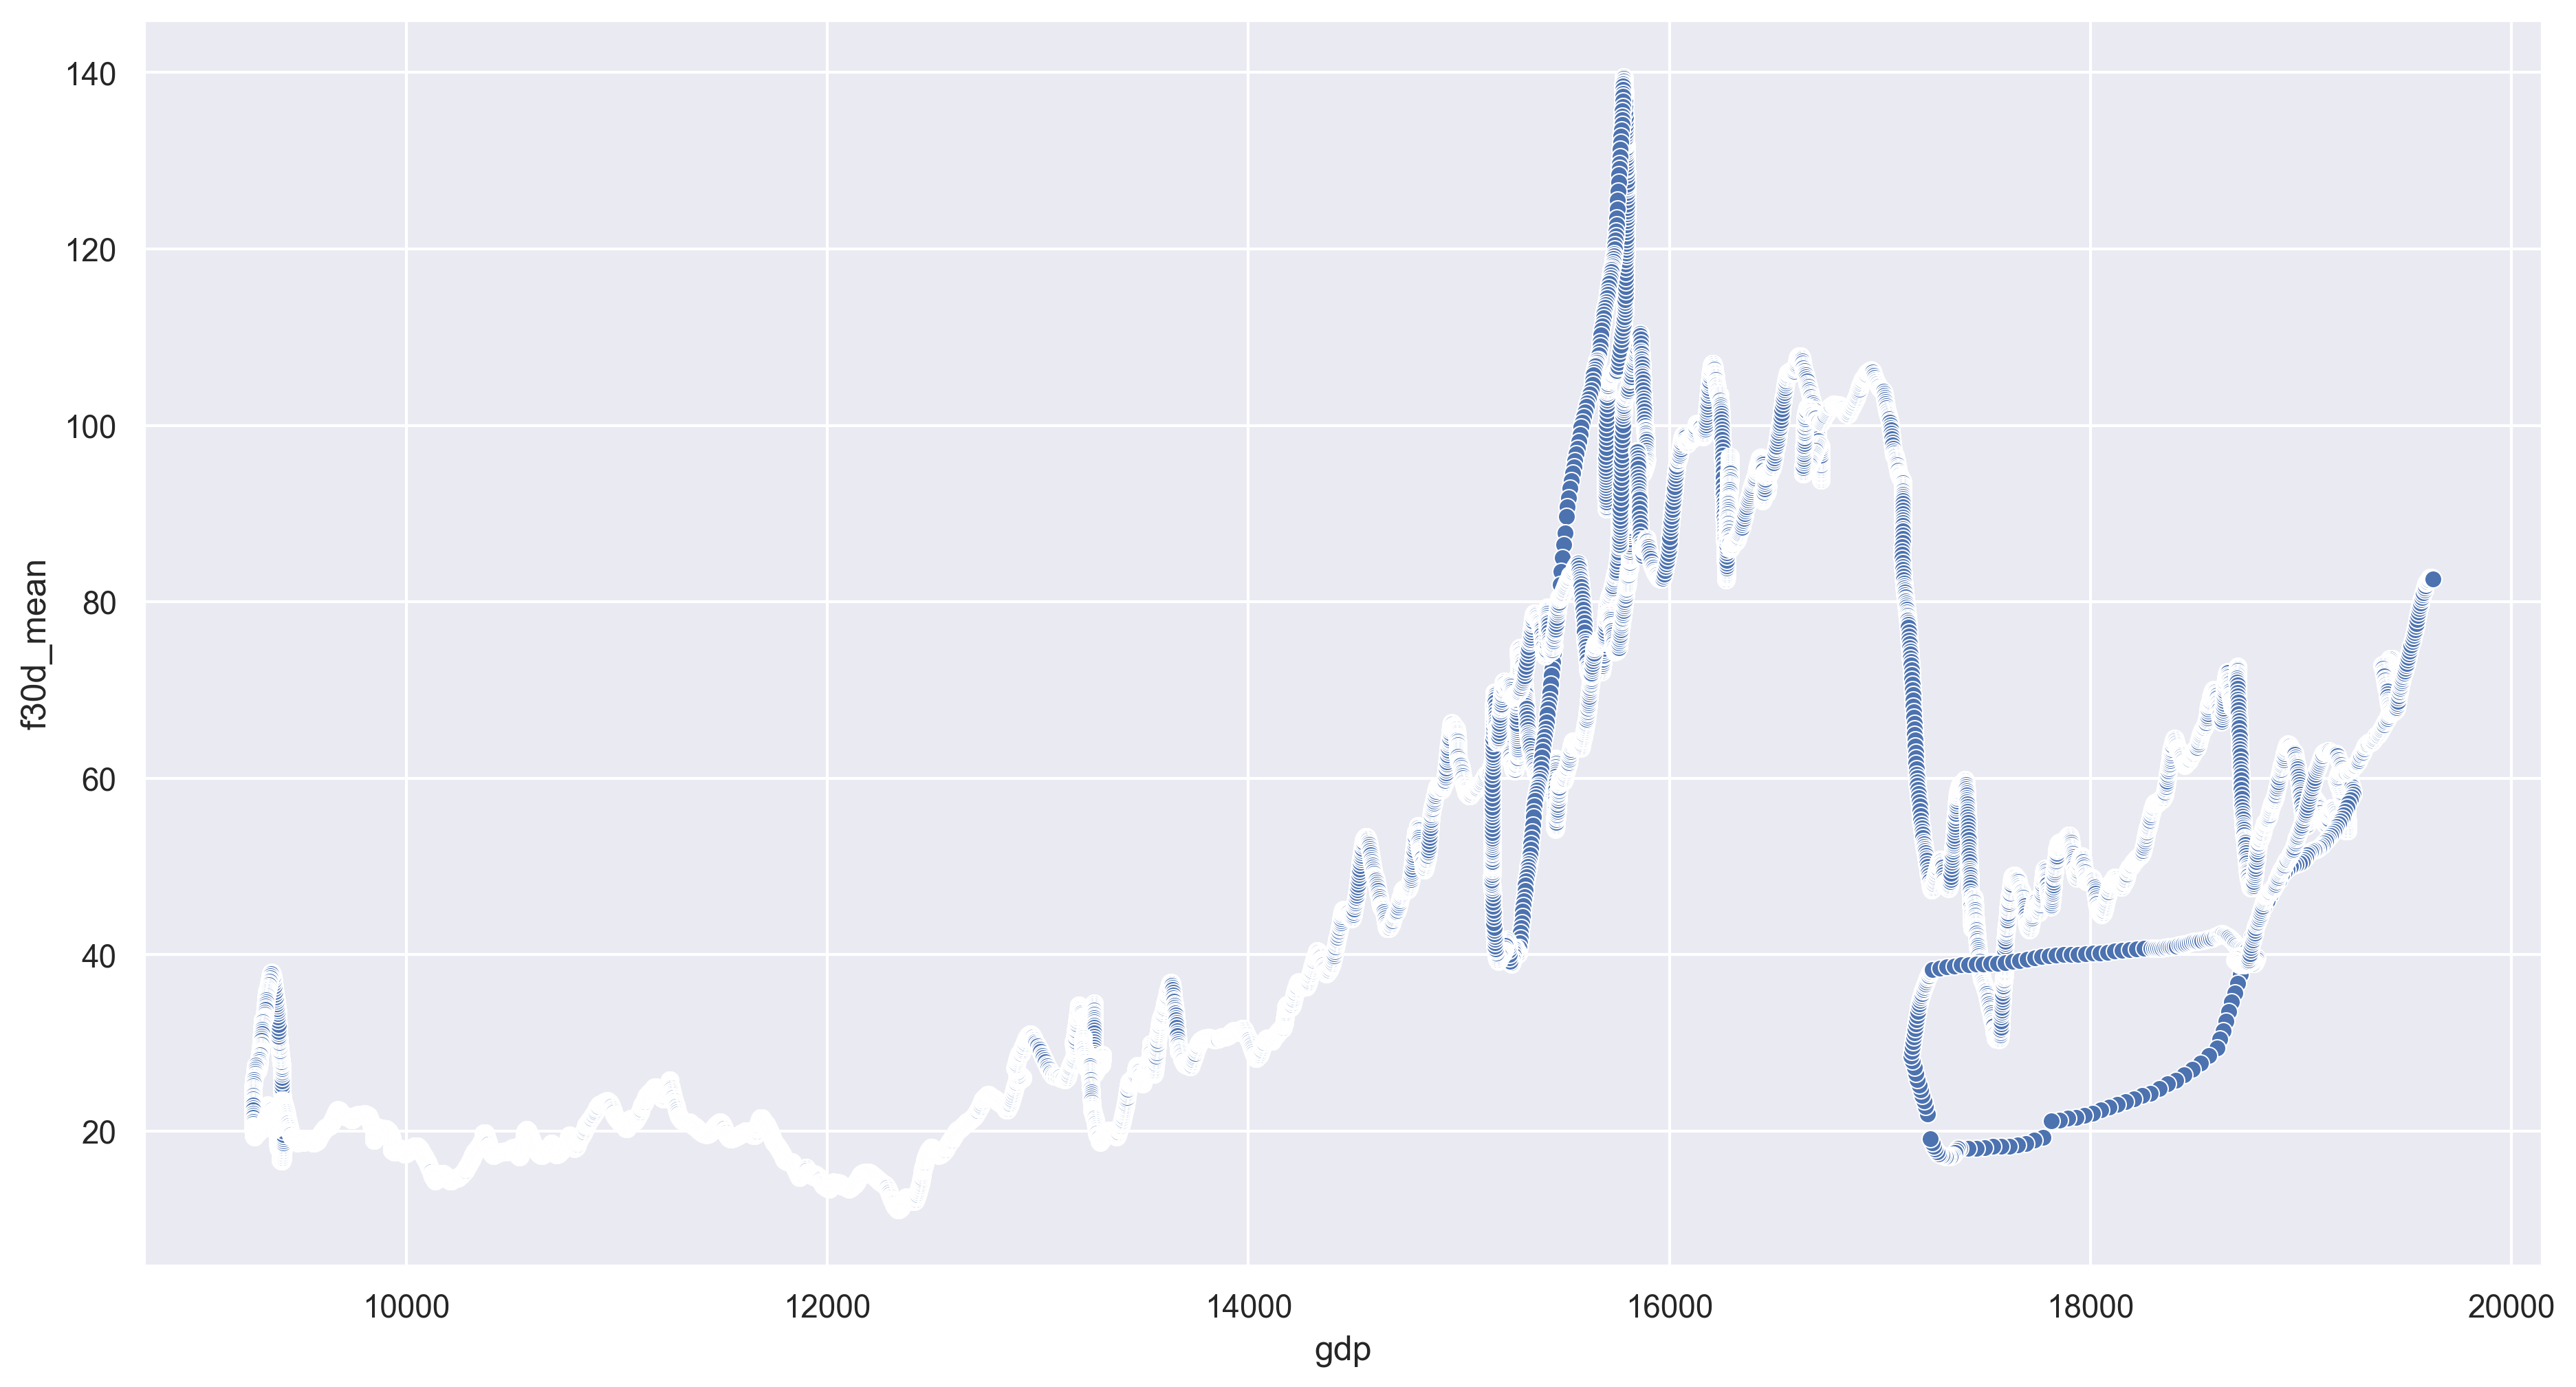

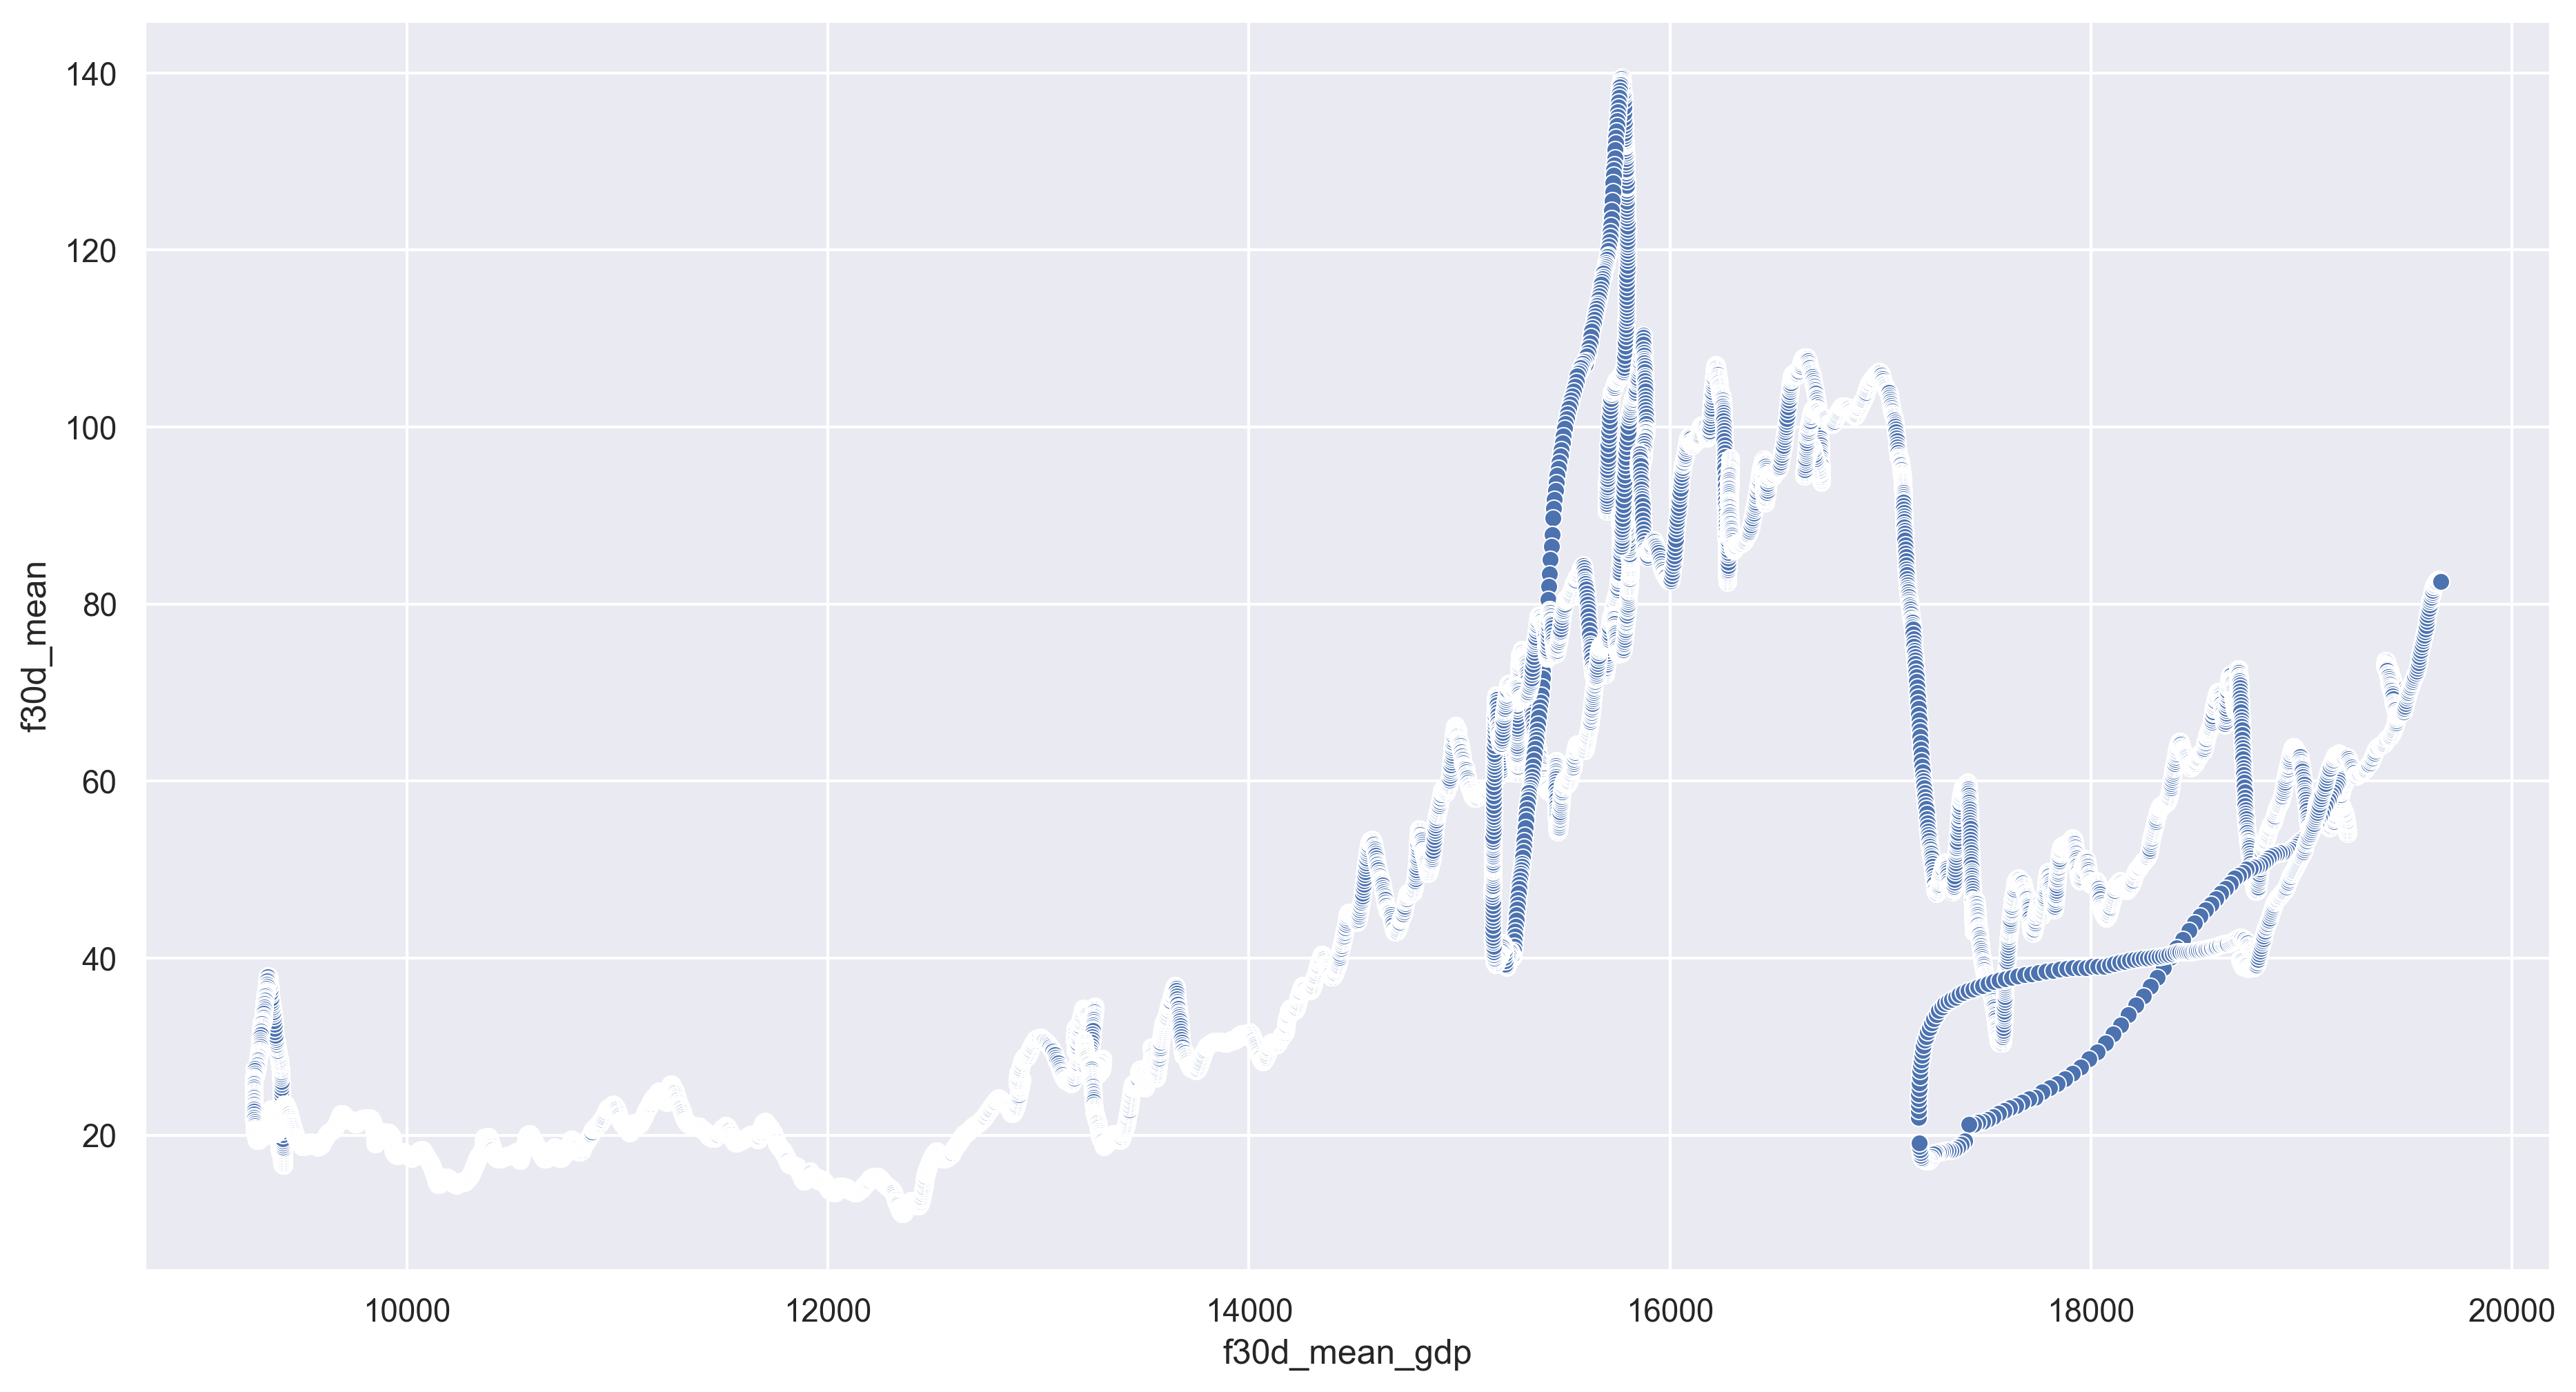

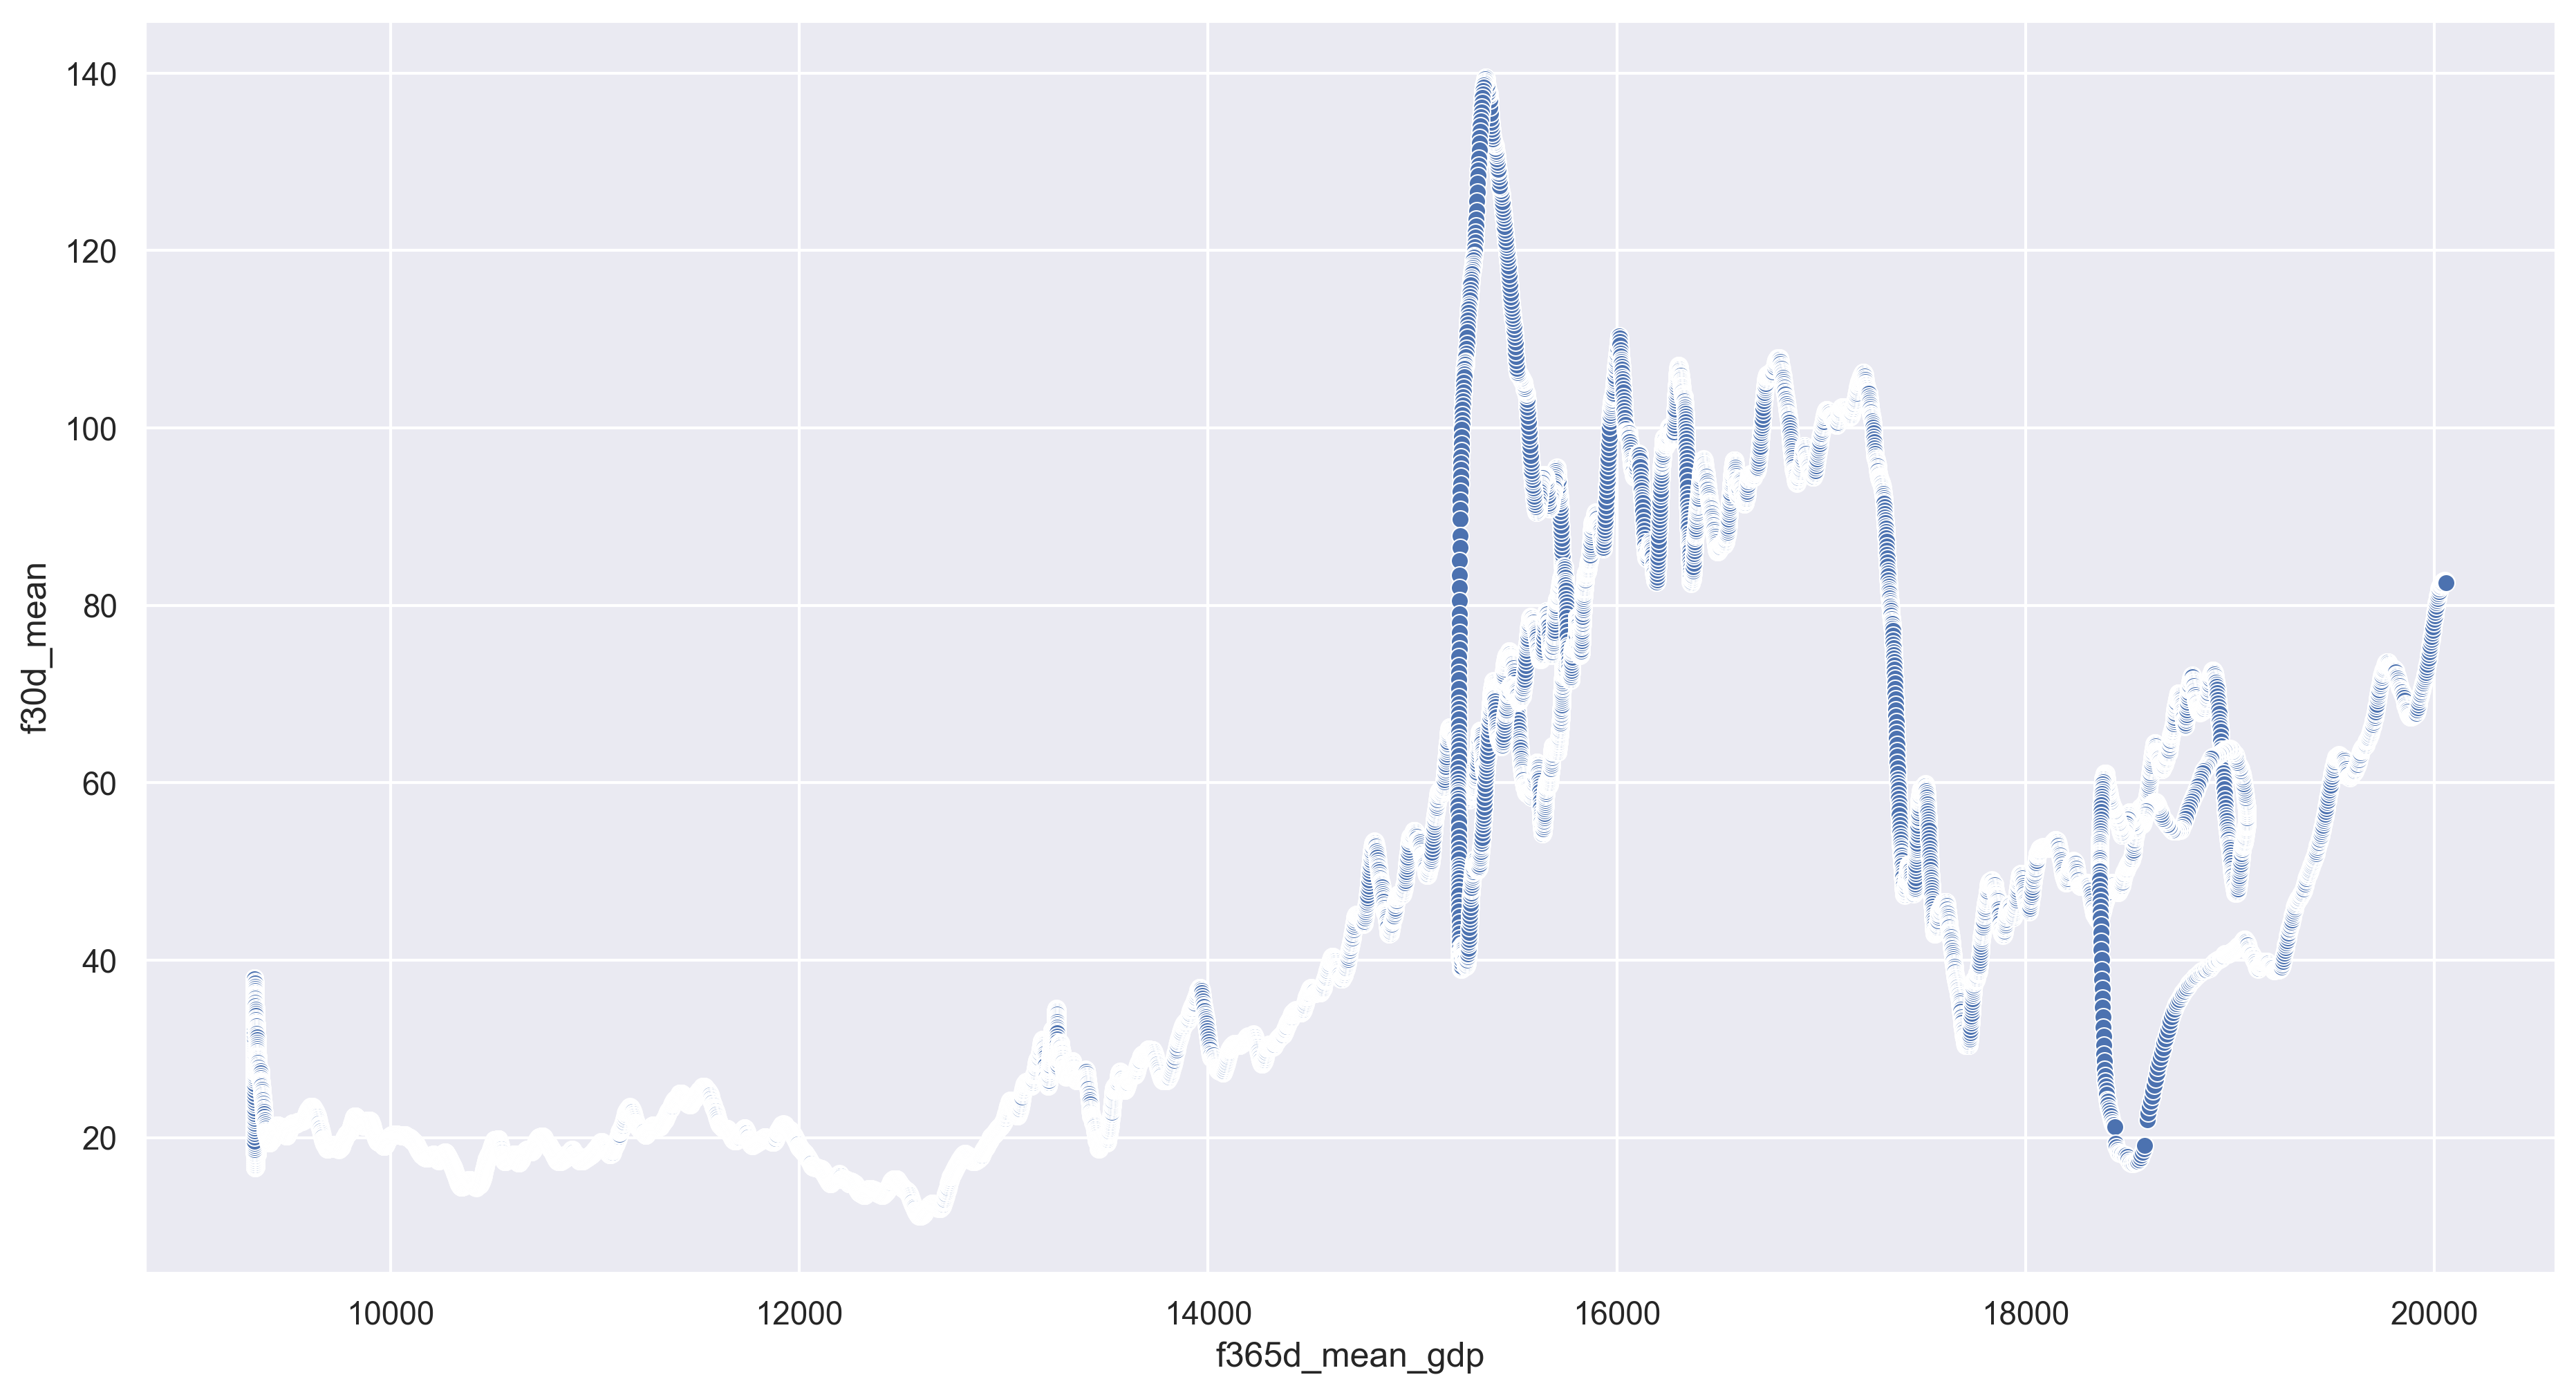

In [16]:
for i in df.drop('f30d_mean', axis=1).columns:
    sns.scatterplot(data=df, x=i, y='f30d_mean')
    plt.show();

In [17]:
# reduce the data for modeling a more recent period, and
# split into input (X) and output (y) datasets:

# X = df[-3000:].reset_index().drop(['f30d_mean', 'index'], axis=1)
# y = df[-3000:].reset_index()['f30d_mean']

X = df.reset_index().drop(['f30d_mean', 'index'], axis=1)
y = df.reset_index()['f30d_mean']

In [18]:
X

price  t90d_mean  US Production  storage           gdp  f30d_mean_gdp  \
0      21.84  20.387000           7565   904134   9340.478778    9352.766670   
1      22.88  20.417111           7565   904134   9341.326219    9353.614111   
2      23.81  20.460000           7565   904134   9342.173660    9354.461552   
3      23.41  20.499111           7565   904134   9343.021100    9355.303125   
4      23.07  20.534444           7512   904076   9343.868541    9356.138830   
...      ...        ...            ...      ...           ...            ...   
11608  81.43  71.349222          11400  1043945  19617.739033   19653.189860   
11609  82.39  71.467333          11300  1041820  19620.178531   19655.643559   
11610  82.39  71.585444          11300  1041820  19622.618029   19658.098442   
11611  82.39  71.762556          11300  1041820  19625.057527   19660.554507   
11612  82.62  71.932556          11300  1041820  19627.497025   19663.011756   

       f365d_mean_gdp  
0         9368.661736  
1         9368.475865  
2         9368.287526  
3         9368.096719  
4         9367.903444  
...               ...  
11608    20048.135191  
11609    20050.372550  
11610    20052.607767  
11611    20054.840844  
11612    20057.071779  

[11613 rows x 7 columns]

In [19]:
y

0        22.904667
1        22.933000
2        22.927333
3        22.901667
4        22.889333
           ...    
11608    82.745000
11609    82.726333
11610    82.675667
11611    82.624333
11612    82.570000
Name: f30d_mean, Length: 11613, dtype: float64

In [20]:
# create the train-test split:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scal = RobustScaler()

X_train = scal.fit_transform(X_train)
X_test = scal.transform(X_test)

In [26]:
# examine X and y shapes:

print('X shape: ' + str(X.shape))
print('y shape: ' + str(y.shape))
print('X_train shape: ' + str(X_train.shape))
print('y_train shape: ' + str(y_train.shape))

X shape: (11613, 7)
y shape: (11613,)
X_train shape: (8129, 7)
y_train shape: (8129,)


In [33]:
# build the neural network:

mod = Sequential()

mod.add(Dense(128, activation='relu'))
mod.add(Dense(128, activation='relu'))
mod.add(Dense(128, activation='relu'))
mod.add(Dense(1))

mod.compile(optimizer='adam', loss='mse')


# set up early stopping:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

# set up checkpoints to recall the best model:
model_cp = tf.keras.callbacks.ModelCheckpoint('best_cp.h5', monitor='val_loss', verbose=1, save_best_only=True)

In [34]:
mod.fit(X_train, y_train, epochs=1000, validation_data=(X_test, y_test), callbacks=[early_stop, model_cp], verbose=0)


Epoch 00001: val_loss improved from inf to 25.56858, saving model to best_cp.h5

Epoch 00002: val_loss improved from 25.56858 to 14.49459, saving model to best_cp.h5

Epoch 00003: val_loss improved from 14.49459 to 9.09965, saving model to best_cp.h5

Epoch 00004: val_loss improved from 9.09965 to 8.79959, saving model to best_cp.h5

Epoch 00005: val_loss improved from 8.79959 to 8.32948, saving model to best_cp.h5

Epoch 00006: val_loss improved from 8.32948 to 7.89628, saving model to best_cp.h5

Epoch 00007: val_loss did not improve from 7.89628

Epoch 00008: val_loss improved from 7.89628 to 7.61801, saving model to best_cp.h5

Epoch 00009: val_loss did not improve from 7.61801

Epoch 00010: val_loss did not improve from 7.61801

Epoch 00011: val_loss did not improve from 7.61801

Epoch 00012: val_loss improved from 7.61801 to 7.51383, saving model to best_cp.h5

Epoch 00013: val_loss did not improve from 7.51383

Epoch 00014: val_loss improved from 7.51383 to 6.96174, saving mode


Epoch 00139: val_loss did not improve from 3.60367

Epoch 00140: val_loss did not improve from 3.60367

Epoch 00141: val_loss did not improve from 3.60367

Epoch 00142: val_loss did not improve from 3.60367

Epoch 00143: val_loss did not improve from 3.60367

Epoch 00144: val_loss improved from 3.60367 to 3.47156, saving model to best_cp.h5

Epoch 00145: val_loss did not improve from 3.47156

Epoch 00146: val_loss improved from 3.47156 to 3.39521, saving model to best_cp.h5

Epoch 00147: val_loss did not improve from 3.39521

Epoch 00148: val_loss did not improve from 3.39521

Epoch 00149: val_loss improved from 3.39521 to 3.37318, saving model to best_cp.h5

Epoch 00150: val_loss improved from 3.37318 to 3.23299, saving model to best_cp.h5

Epoch 00151: val_loss did not improve from 3.23299

Epoch 00152: val_loss did not improve from 3.23299

Epoch 00153: val_loss improved from 3.23299 to 3.22457, saving model to best_cp.h5

Epoch 00154: val_loss did not improve from 3.22457

Epoch 0


Epoch 00282: val_loss did not improve from 1.66812

Epoch 00283: val_loss did not improve from 1.66812

Epoch 00284: val_loss did not improve from 1.66812

Epoch 00285: val_loss did not improve from 1.66812

Epoch 00286: val_loss did not improve from 1.66812

Epoch 00287: val_loss improved from 1.66812 to 1.60610, saving model to best_cp.h5

Epoch 00288: val_loss did not improve from 1.60610

Epoch 00289: val_loss did not improve from 1.60610

Epoch 00290: val_loss did not improve from 1.60610

Epoch 00291: val_loss did not improve from 1.60610

Epoch 00292: val_loss did not improve from 1.60610

Epoch 00293: val_loss did not improve from 1.60610

Epoch 00294: val_loss did not improve from 1.60610

Epoch 00295: val_loss did not improve from 1.60610

Epoch 00296: val_loss did not improve from 1.60610

Epoch 00297: val_loss did not improve from 1.60610

Epoch 00298: val_loss did not improve from 1.60610

Epoch 00299: val_loss did not improve from 1.60610

Epoch 00300: val_loss did not i

(0.0, 20.0)

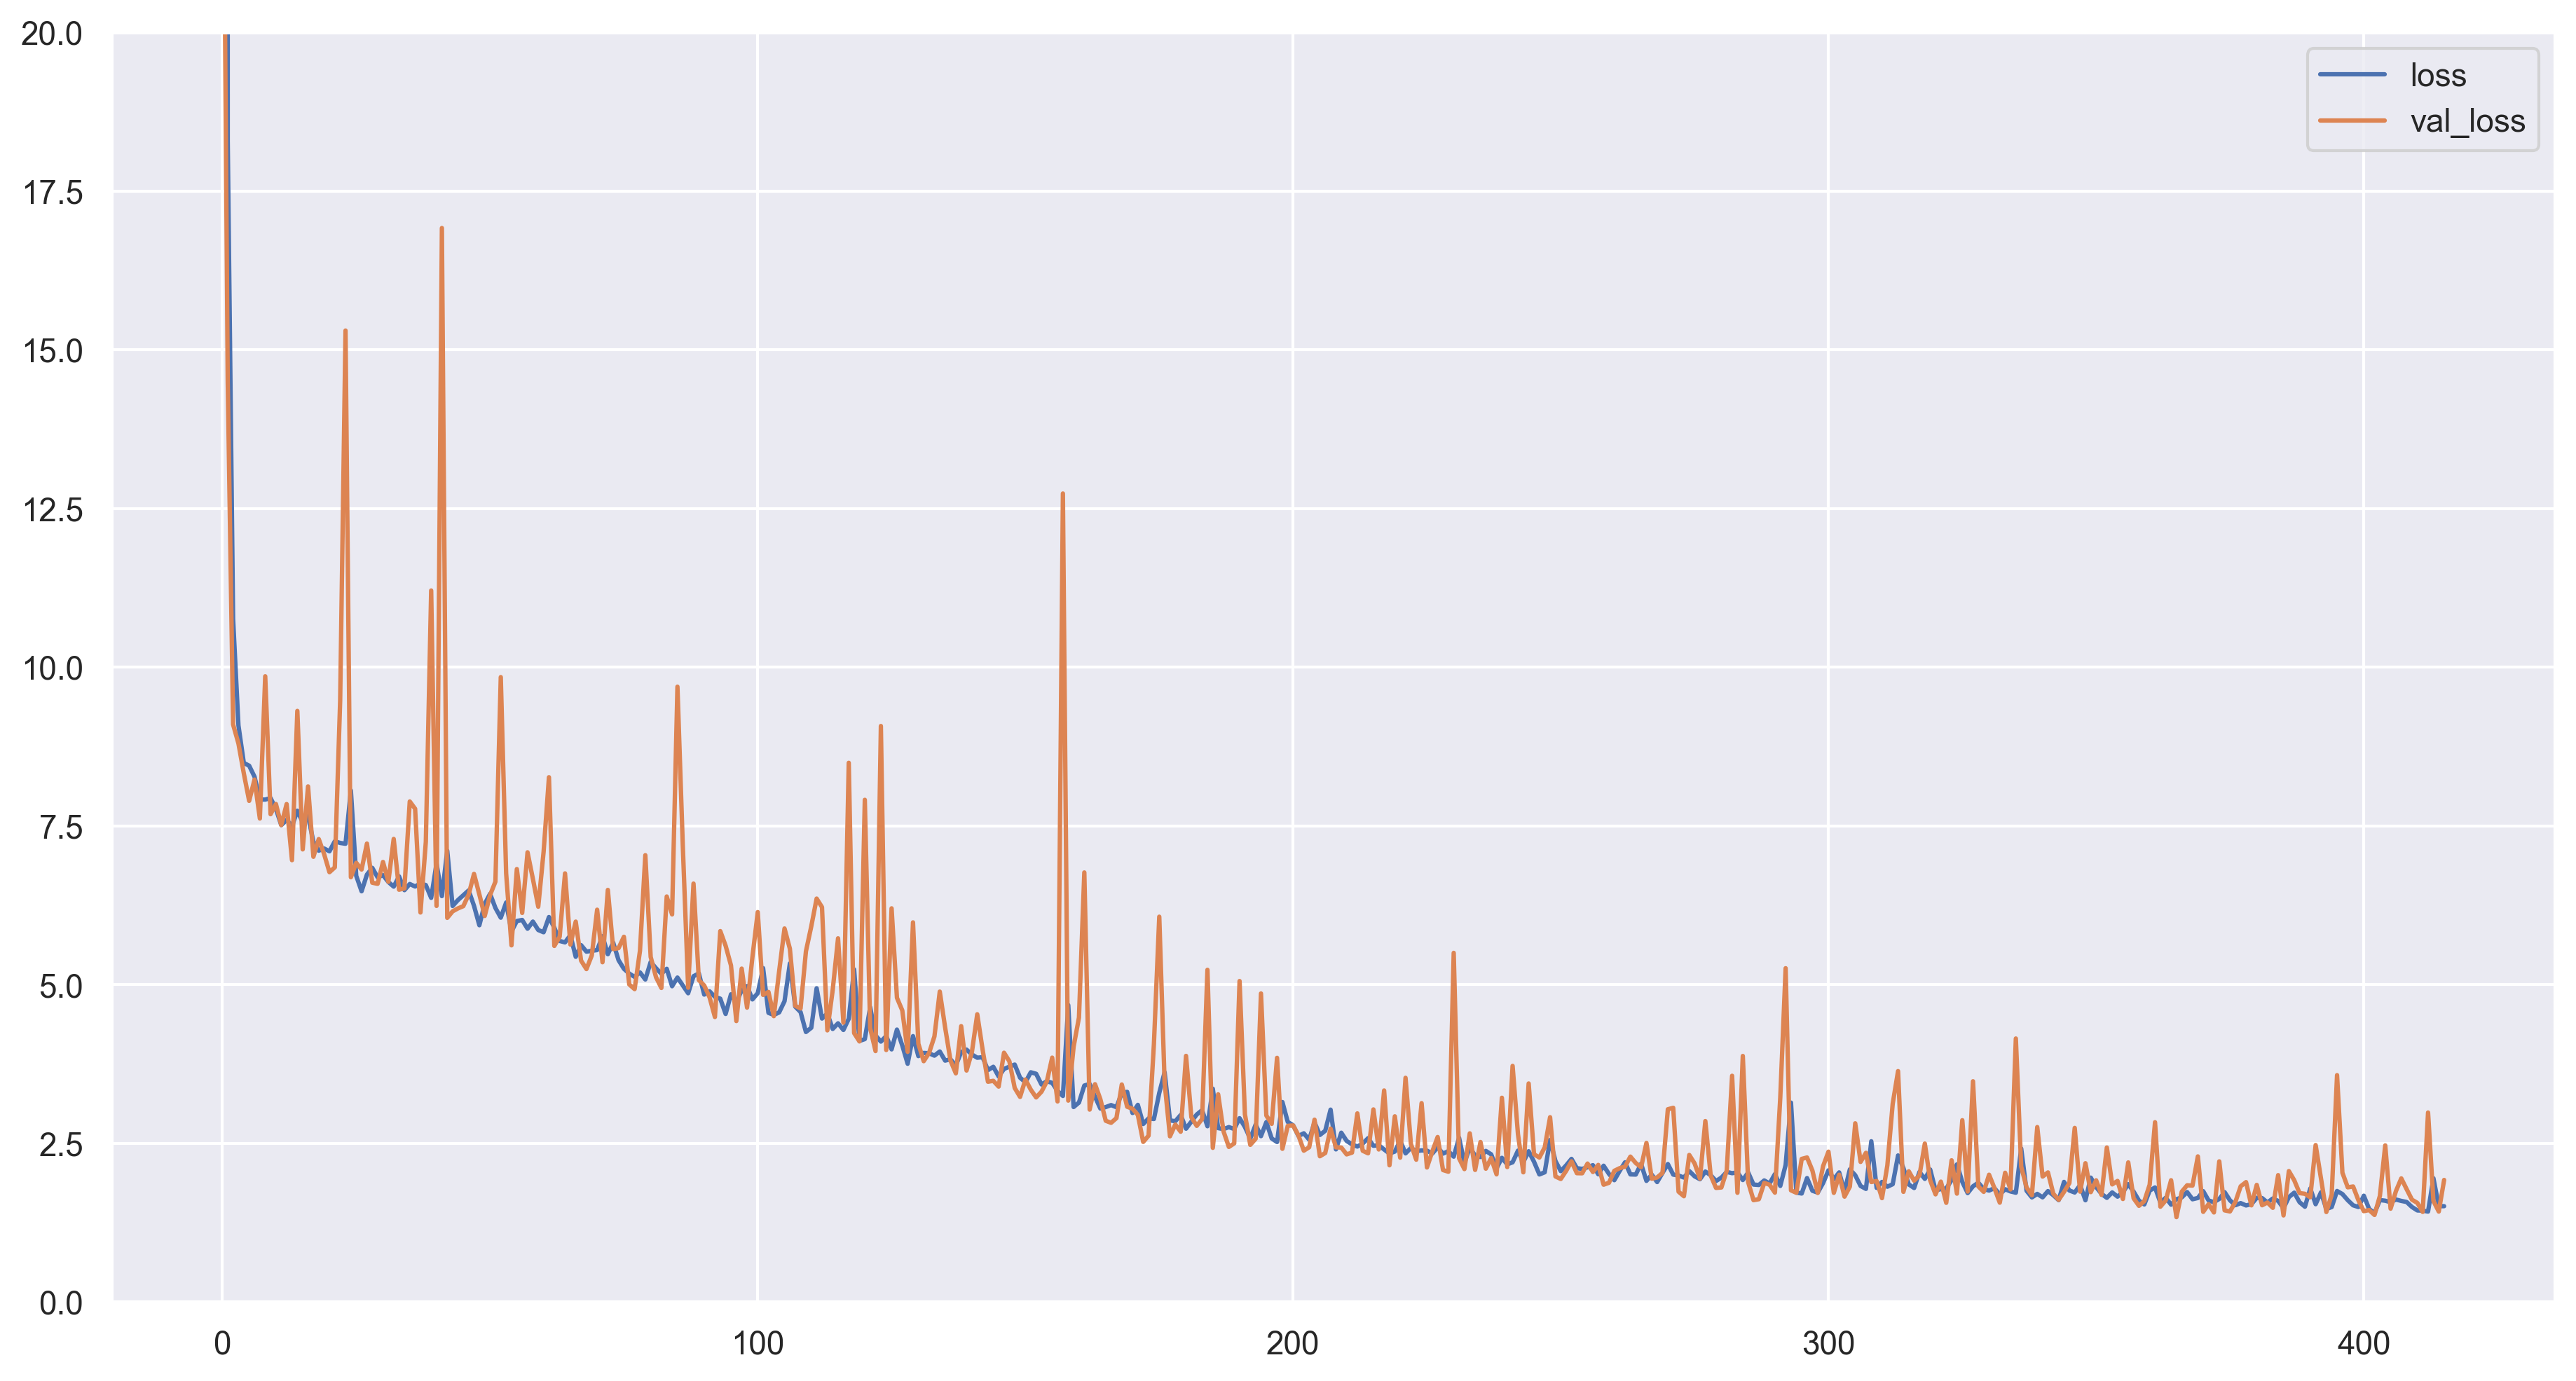

In [36]:
# view the history of model loss & validation loss:

history = pd.DataFrame(mod.history.history).plot()
history

plt.ylim(0, 20)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


(0.0, 145.78884999999997)

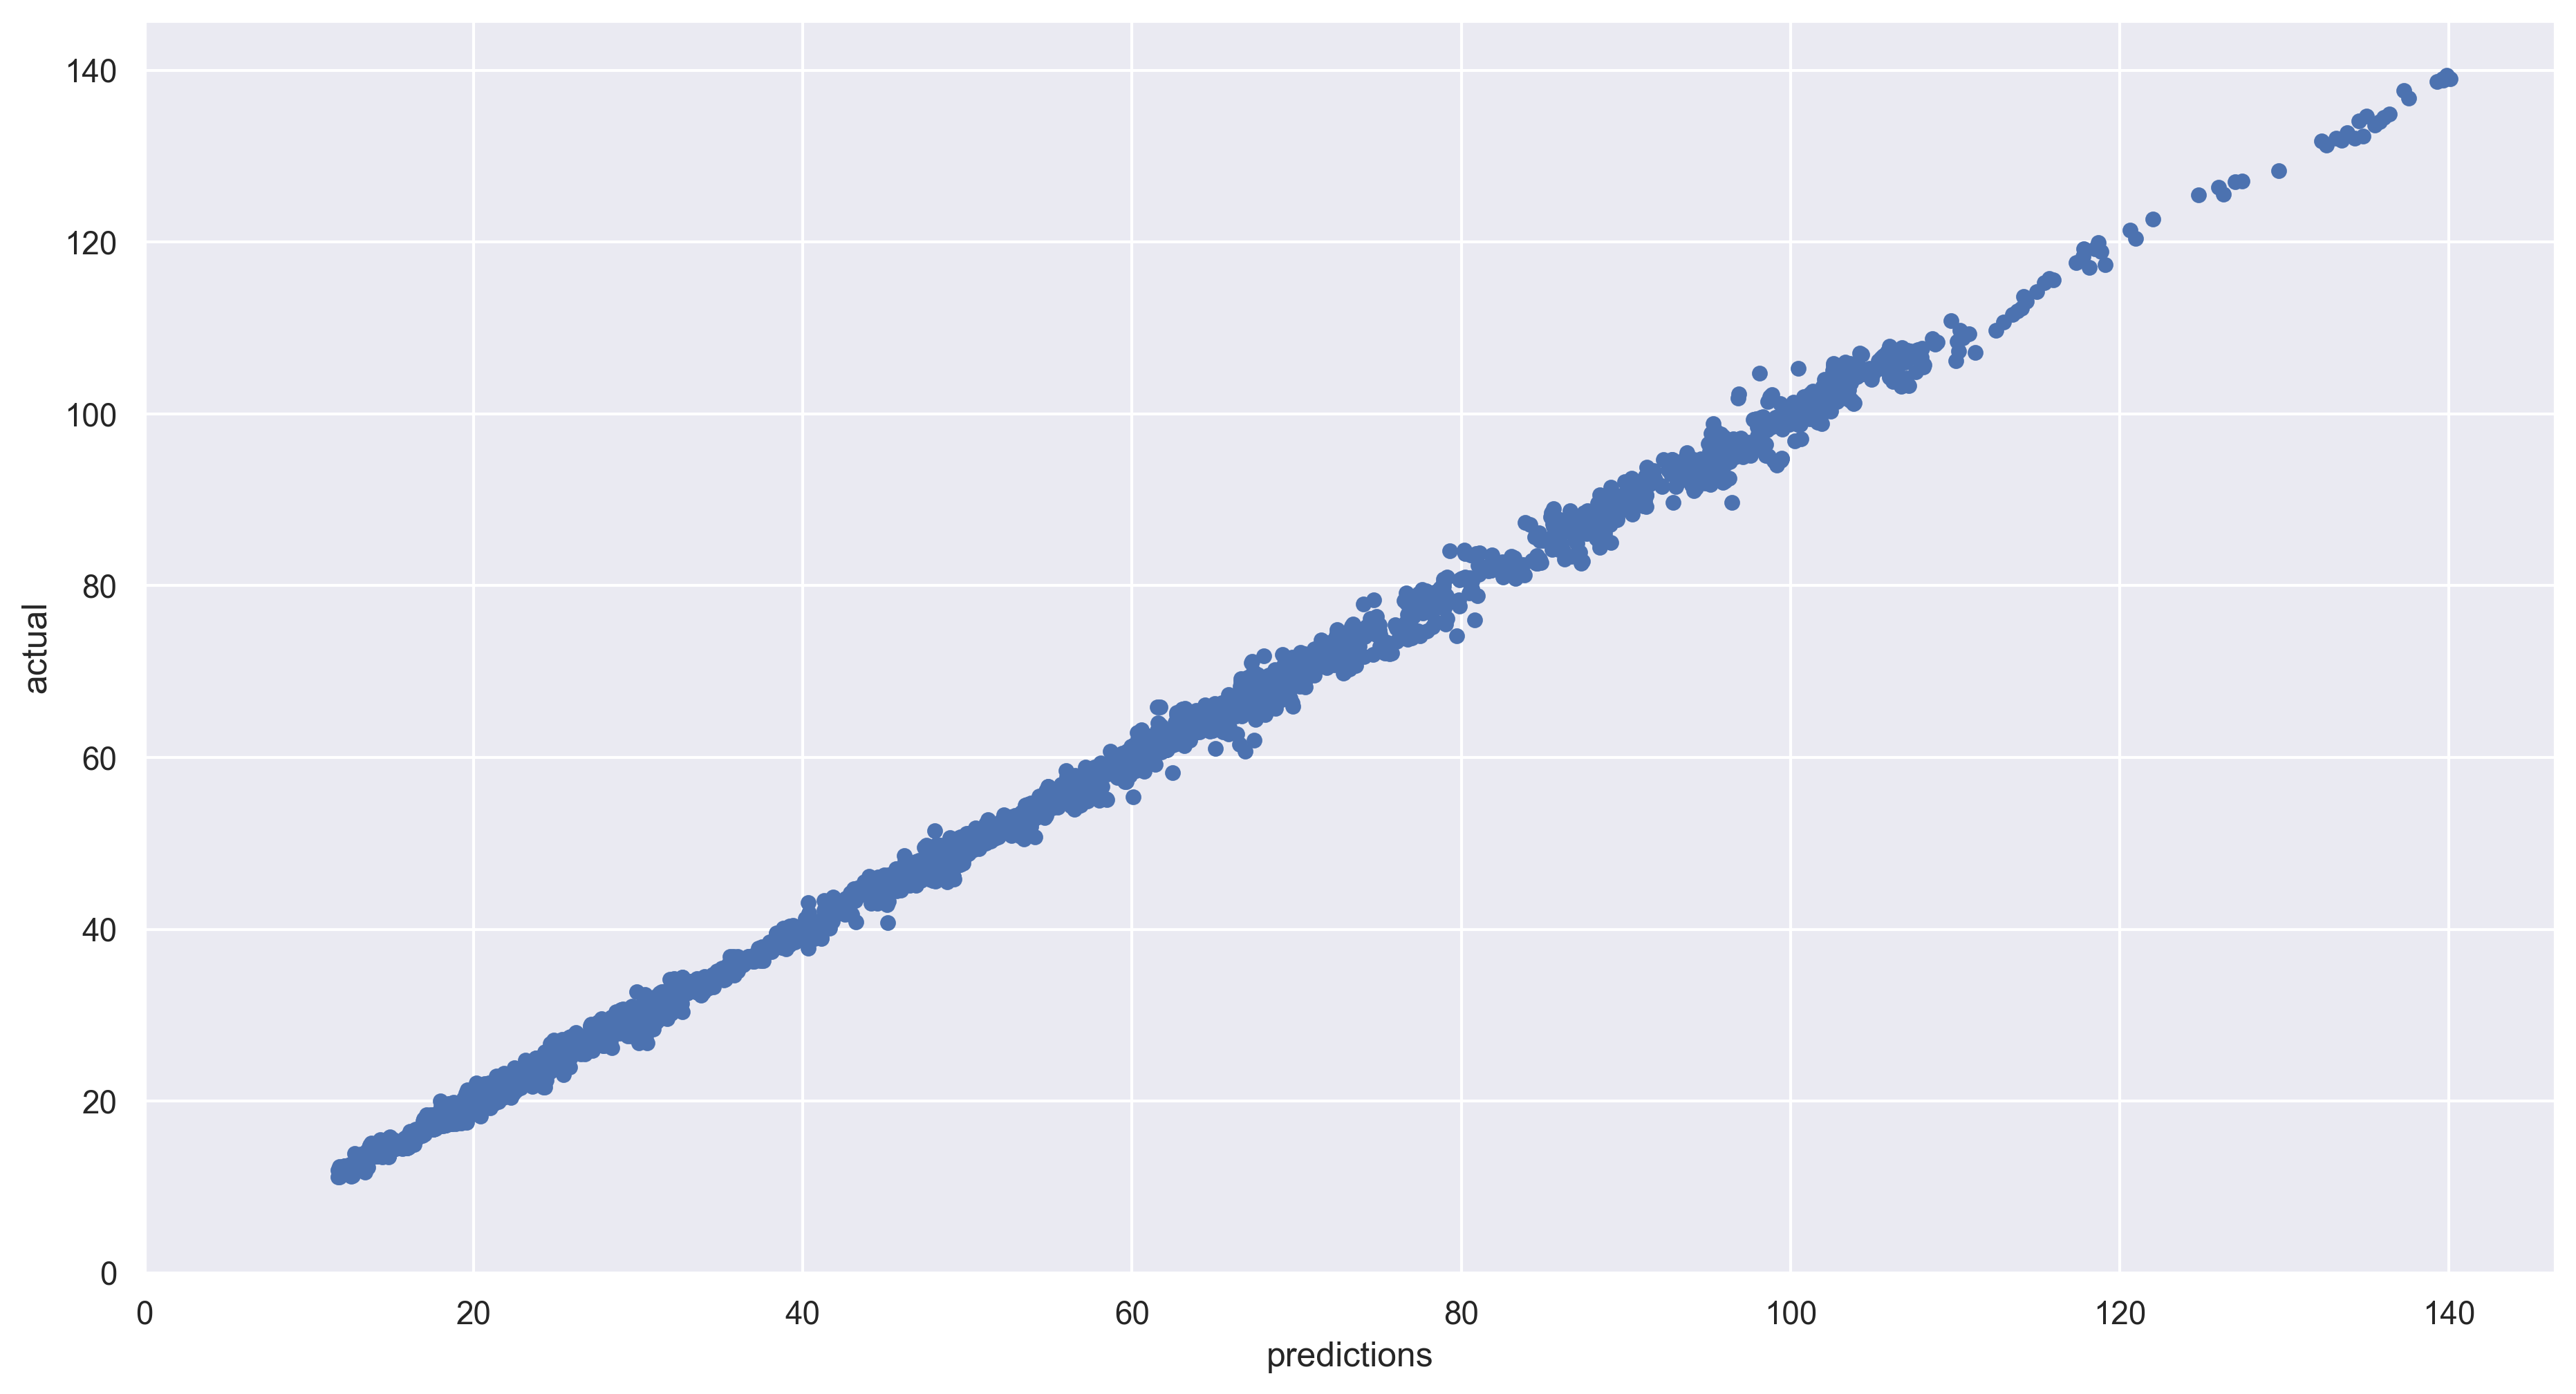

In [37]:
# recall the best model:
mod = tf.keras.models.load_model('best_cp.h5')


# create and view predictions versus actual for test data:

predictions = mod.predict(X_test).reshape(y_test.shape)
pd.DataFrame({'predictions': predictions, 'actual': y_test}).plot.scatter(x='predictions', y='actual', figsize=(15,8))
plt.xlim(0,)
plt.ylim(0,)

In [38]:
# add a model prediction column to the original dataframe
# (note the model does not treat the data as a time series):

ts = df.copy()
ts['f30d_pred'] = mod.predict(scal.transform(df[X.columns].values))
ts

price  t90d_mean  f30d_mean  US Production  storage           gdp  \
1990-01-01  21.84  20.387000  22.904667           7565   904134   9340.478778   
1990-01-02  22.88  20.417111  22.933000           7565   904134   9341.326219   
1990-01-03  23.81  20.460000  22.927333           7565   904134   9342.173660   
1990-01-04  23.41  20.499111  22.901667           7565   904134   9343.021100   
1990-01-05  23.07  20.534444  22.889333           7512   904076   9343.868541   
...           ...        ...        ...            ...      ...           ...   
2021-10-14  81.43  71.349222  82.745000          11400  1043945  19617.739033   
2021-10-15  82.39  71.467333  82.726333          11300  1041820  19620.178531   
2021-10-16  82.39  71.585444  82.675667          11300  1041820  19622.618029   
2021-10-17  82.39  71.762556  82.624333          11300  1041820  19625.057527   
2021-10-18  82.62  71.932556  82.570000          11300  1041820  19627.497025   

            f30d_mean_gdp  f365d_mean_gdp  f30d_pred  
1990-01-01    9352.766670     9368.661736  21.392731  
1990-01-02    9353.614111     9368.475865  22.364090  
1990-01-03    9354.461552     9368.287526  23.228374  
1990-01-04    9355.303125     9368.096719  22.840656  
1990-01-05    9356.138830     9367.903444  22.659544  
...                   ...             ...        ...  
2021-10-14   19653.189860    20048.135191  82.479721  
2021-10-15   19655.643559    20050.372550  84.706635  
2021-10-16   19658.098442    20052.607767  84.648796  
2021-10-17   19660.554507    20054.840844  84.537514  
2021-10-18   19663.011756    20057.071779  84.634003  

[11613 rows x 9 columns]

<AxesSubplot:>

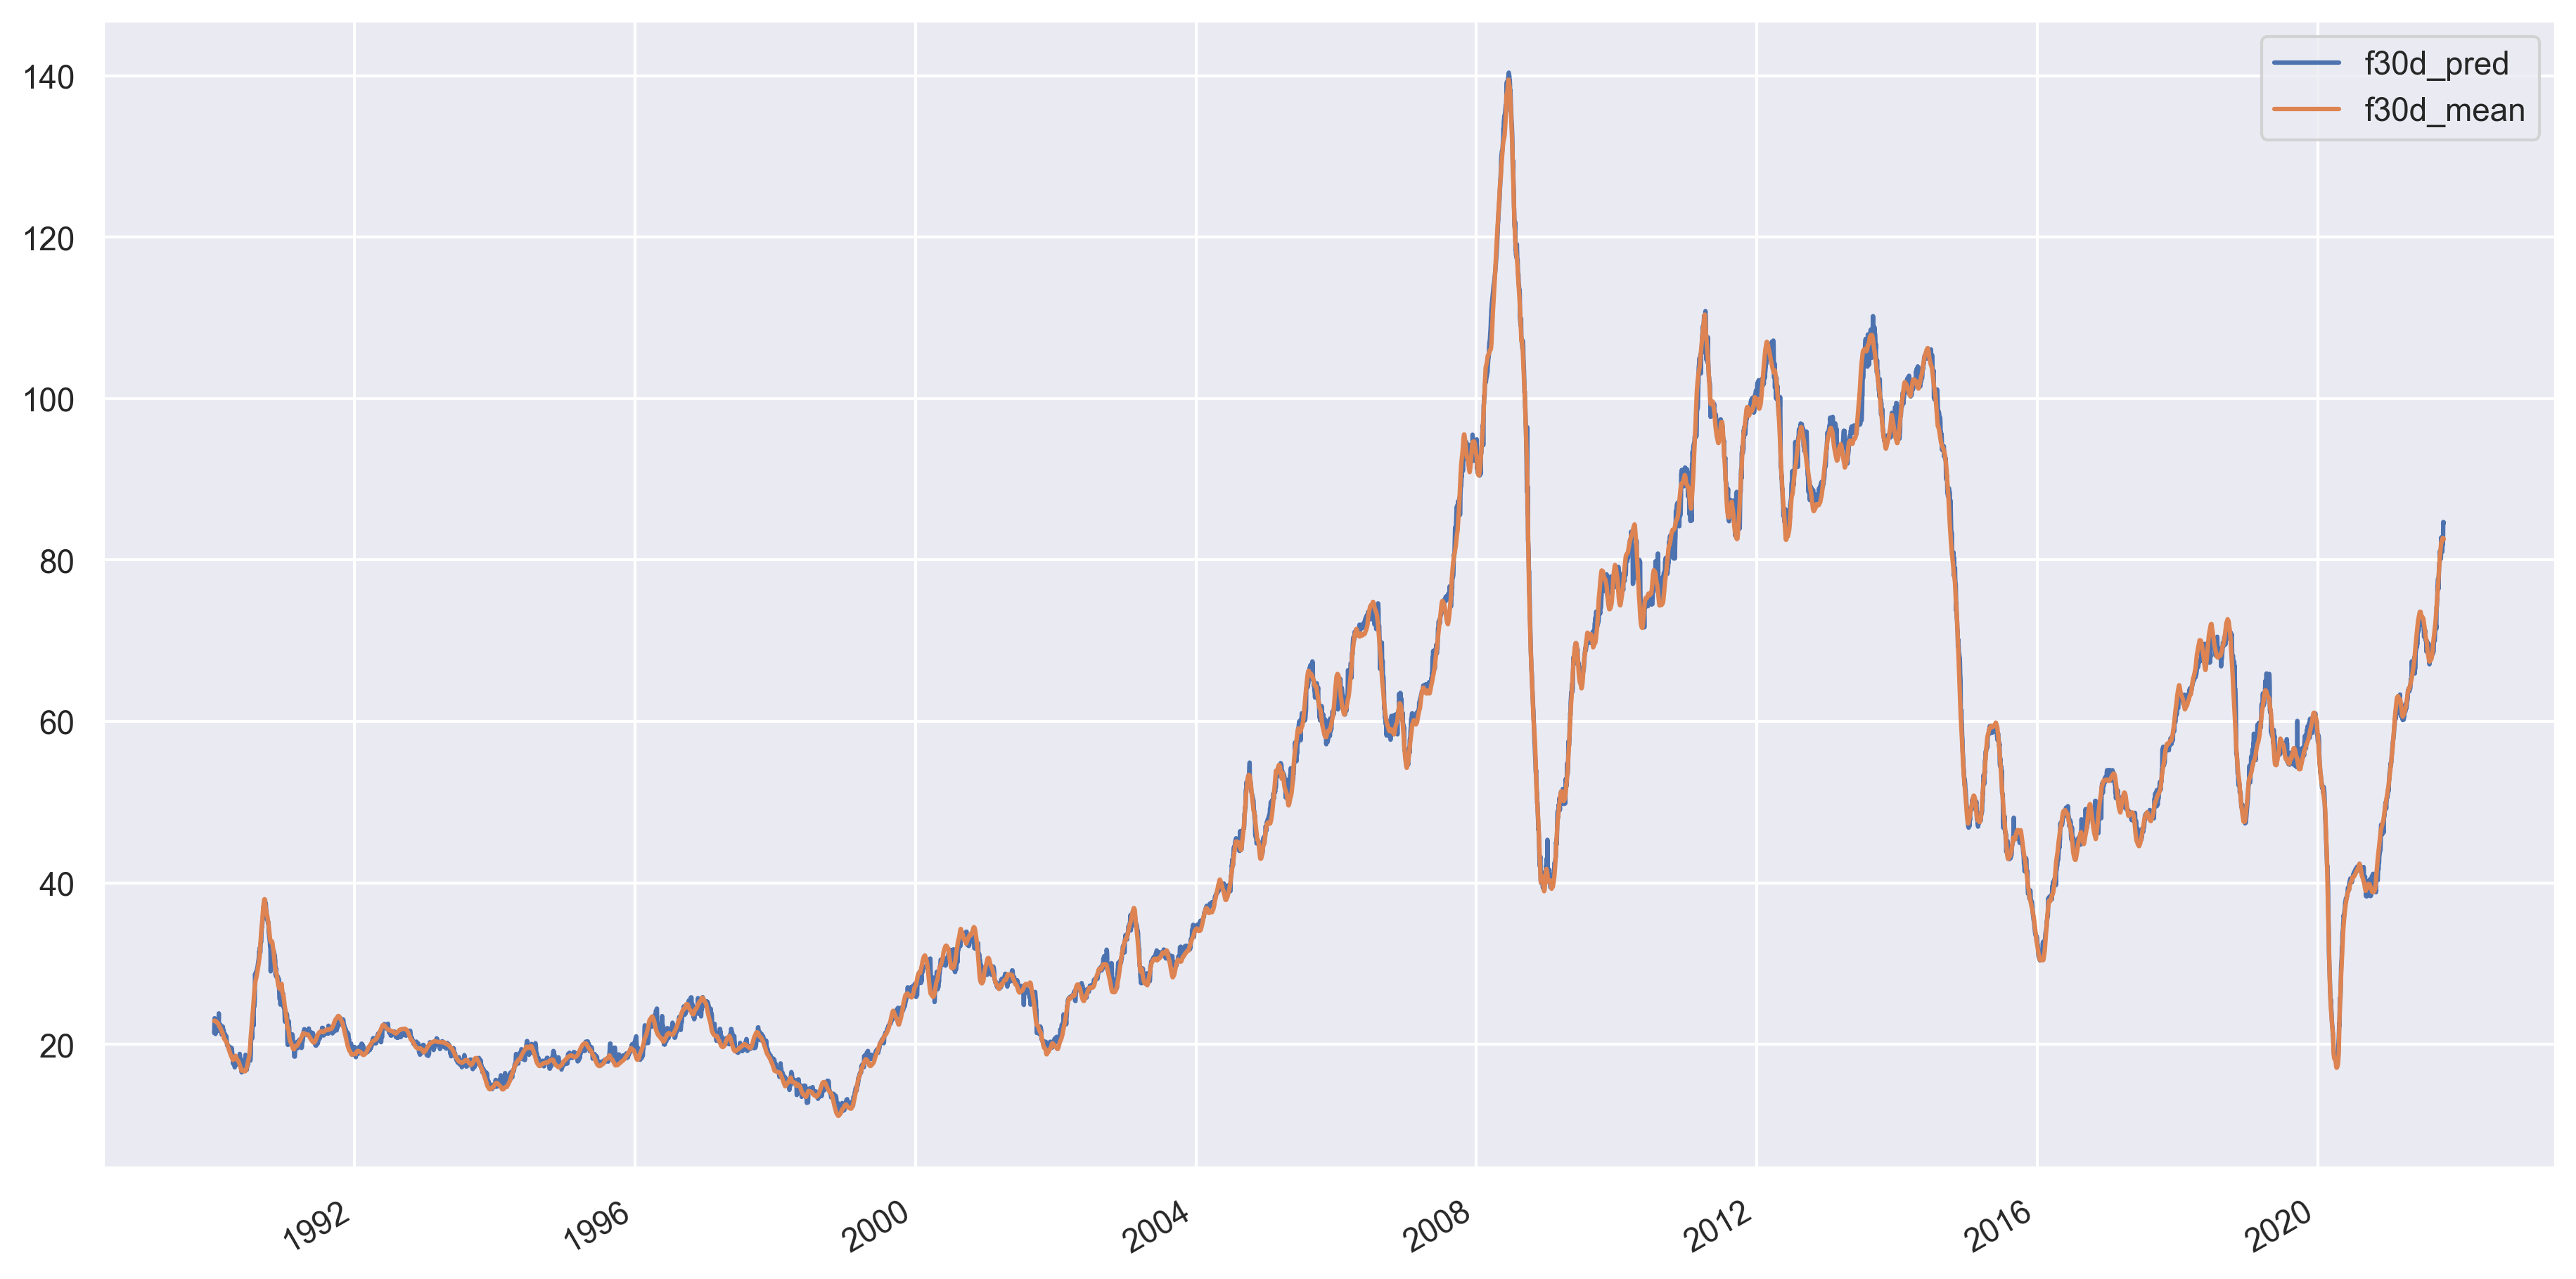

In [39]:
ts[['f30d_pred', 'f30d_mean']].plot(figsize=(15,8))

<AxesSubplot:>

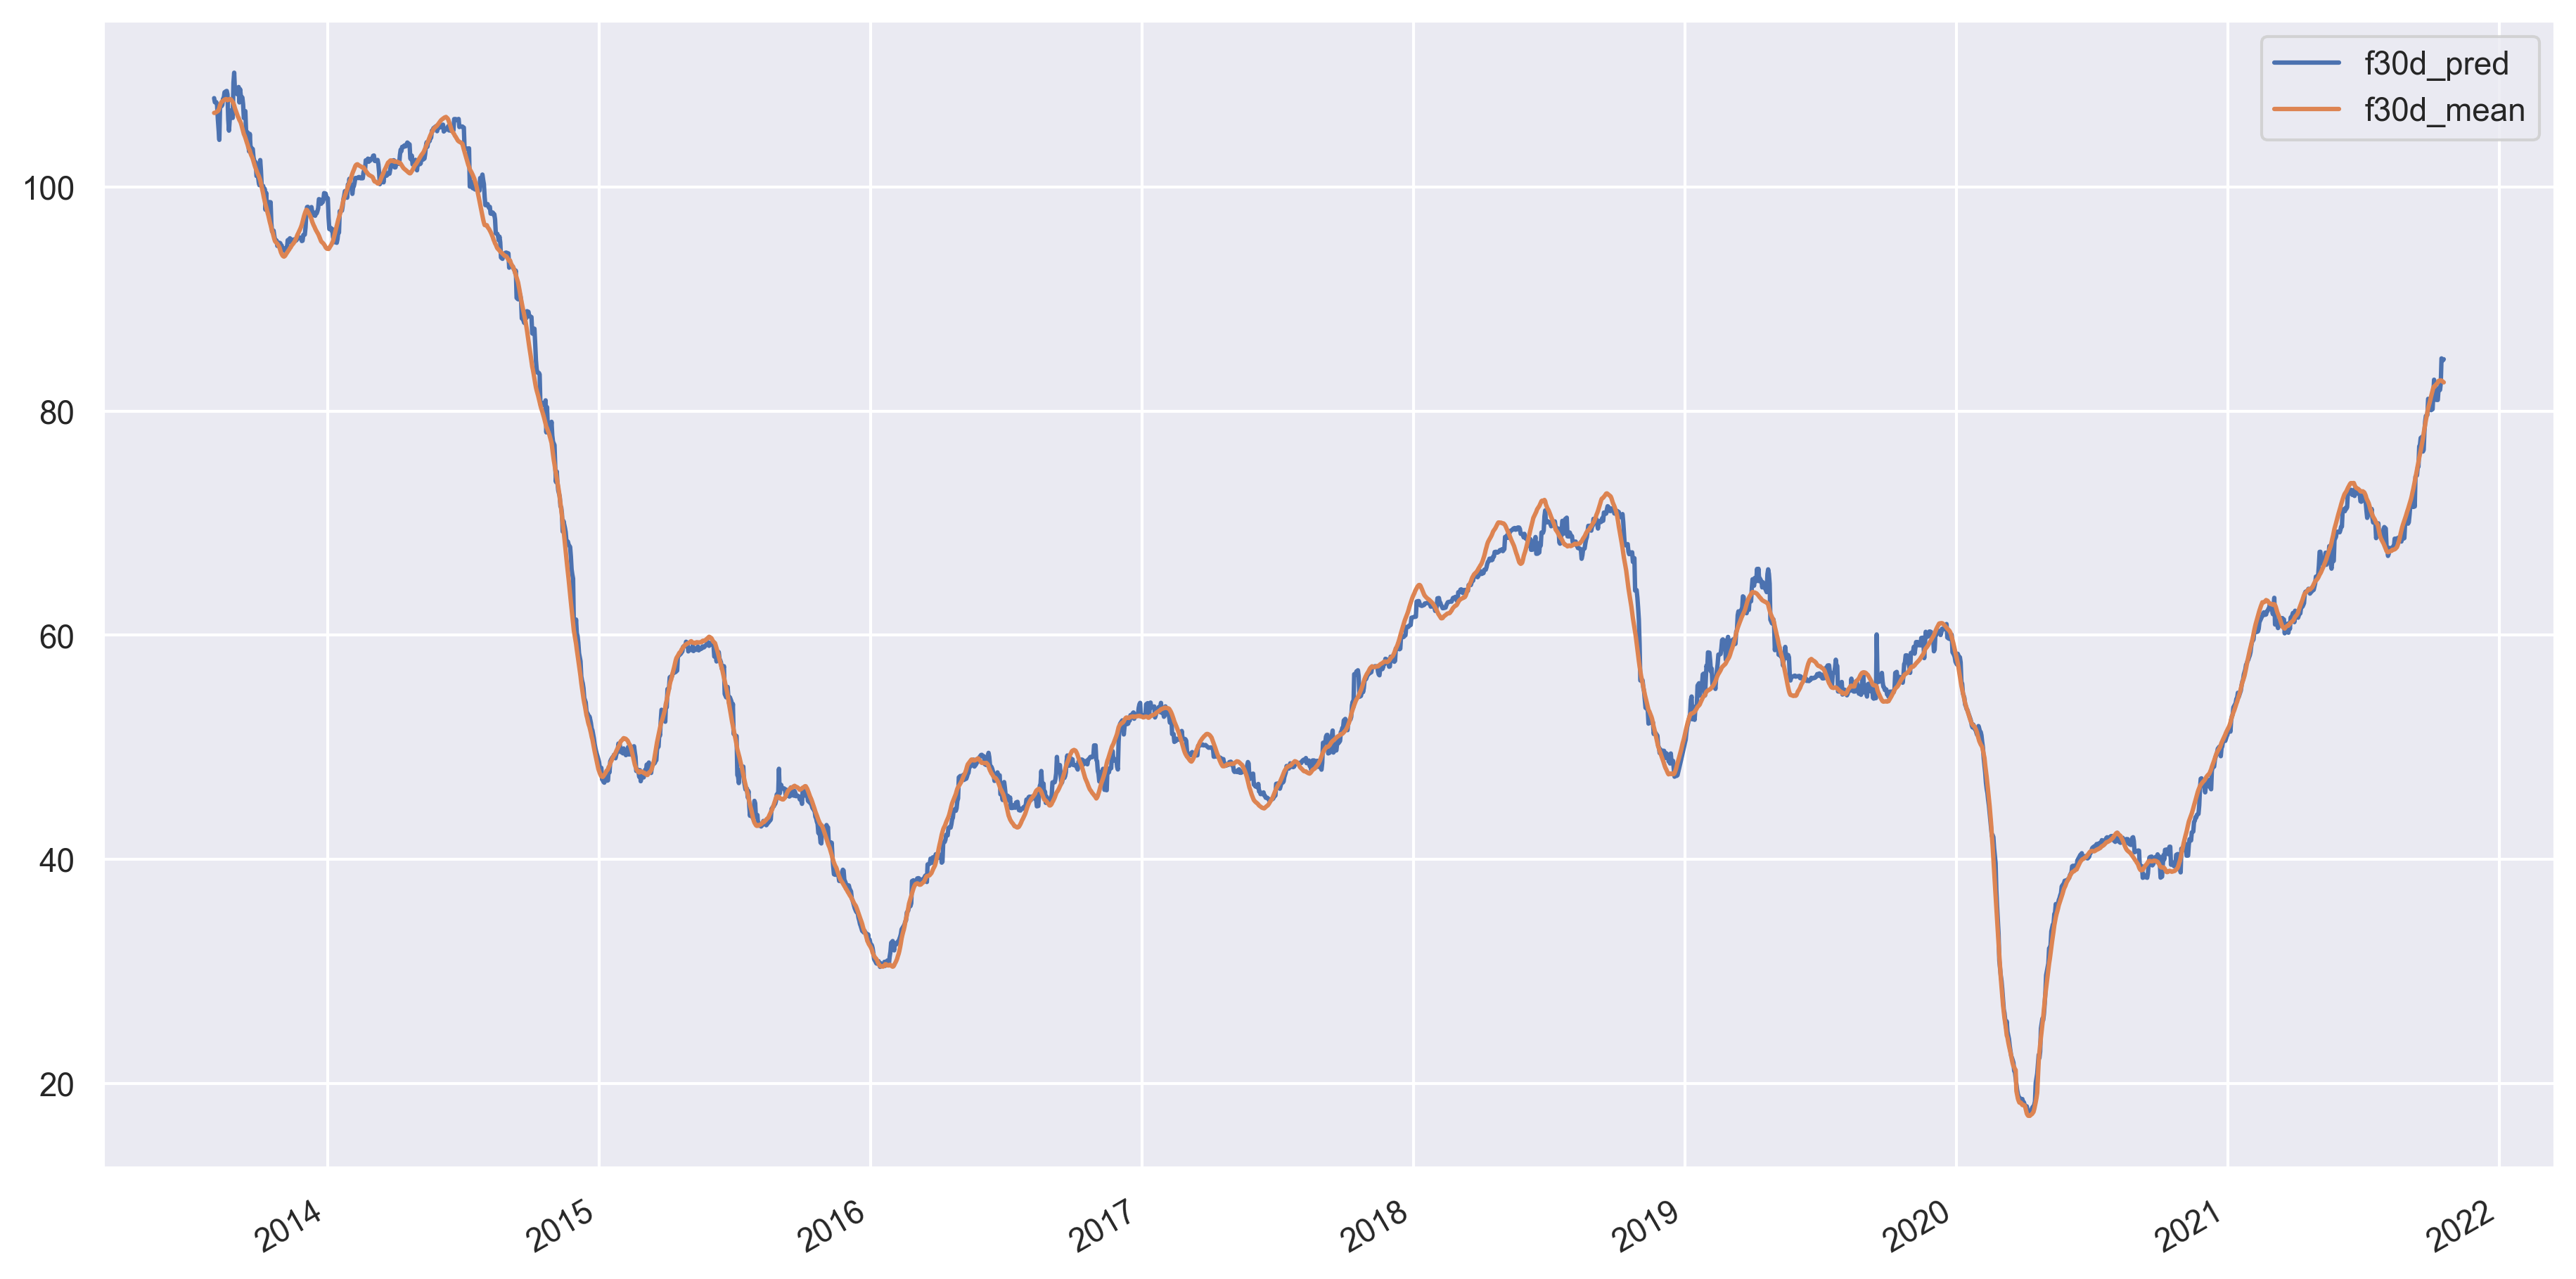

In [40]:
ts[-3000:][['f30d_pred', 'f30d_mean']].plot(figsize=(15,8))

(0.0, 88.4964662475586)

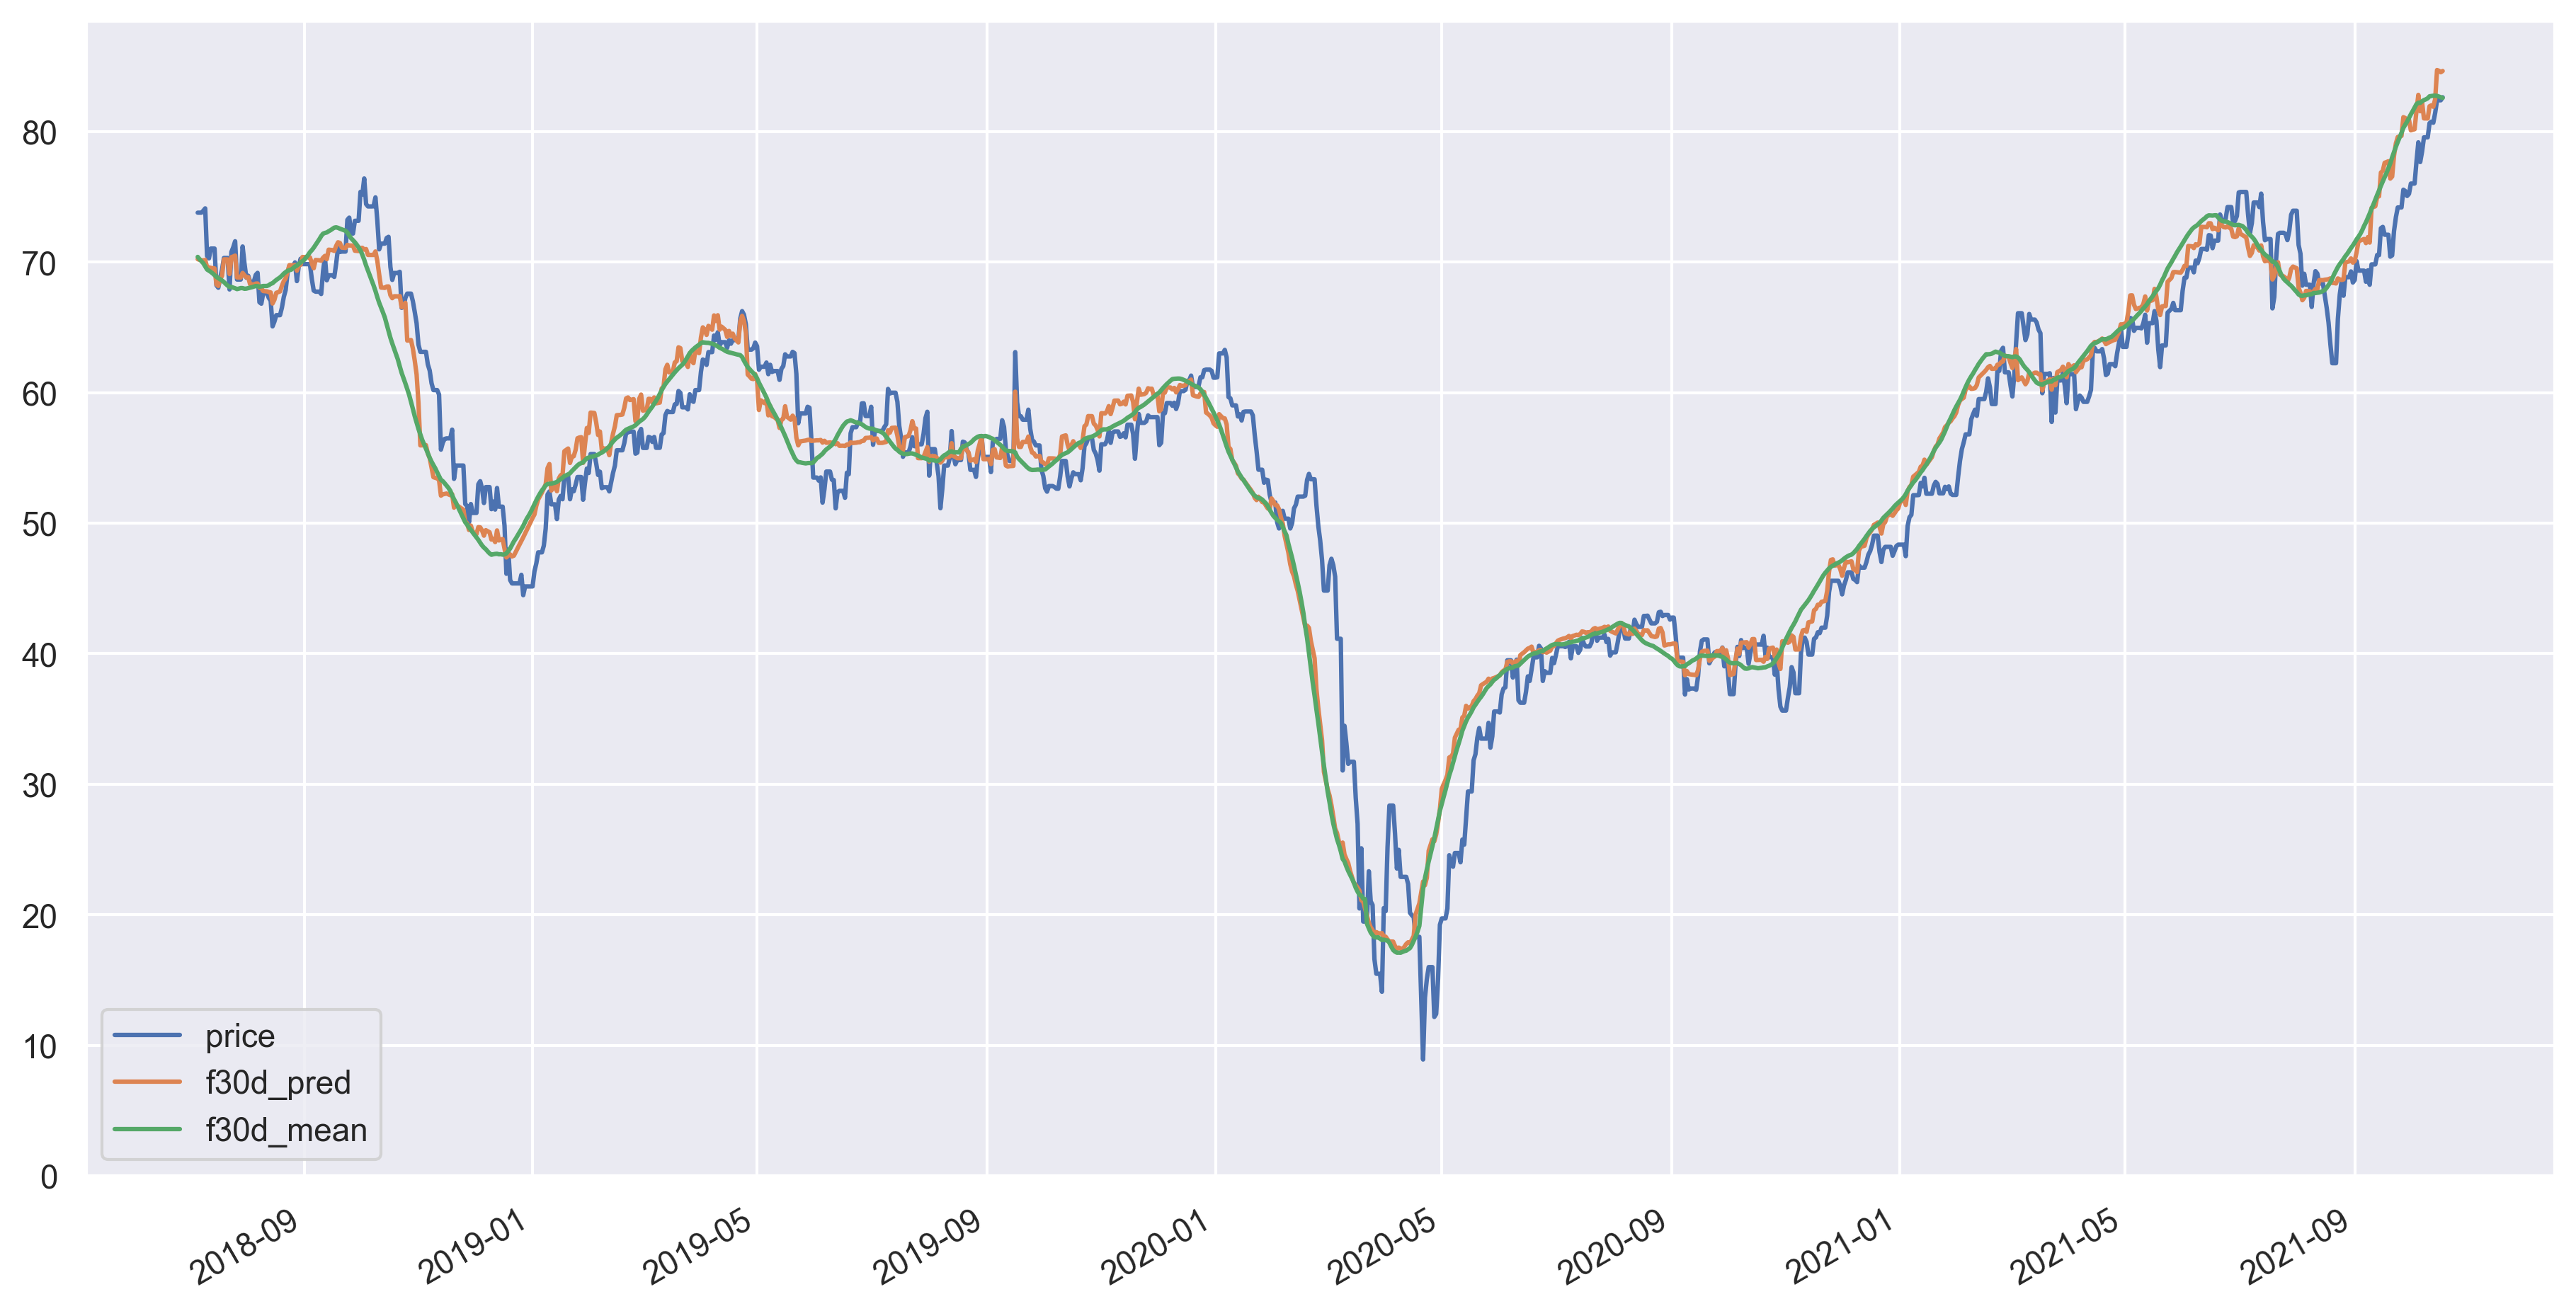

In [41]:
ts[-1200:][['price', 'f30d_pred', 'f30d_mean']].plot()

plt.ylim(0,)

<h1><u>Comparison to Baseline</u></h1>

### It's common to base economic assumptions on the presumption, for lack of better information, that ongoing oil prices remain flat. The model at issue should at least improve upon this as a baseline. 

#### I'm considering two alternative baselines which may add to or replace the current (daily spot rate) baseline:
- 30-days average spot price (similar to daily but more stable)
- Trailing 12-months average spot price (basis for SEC booked reserves economics)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='price', ylabel='f30d_mean'>

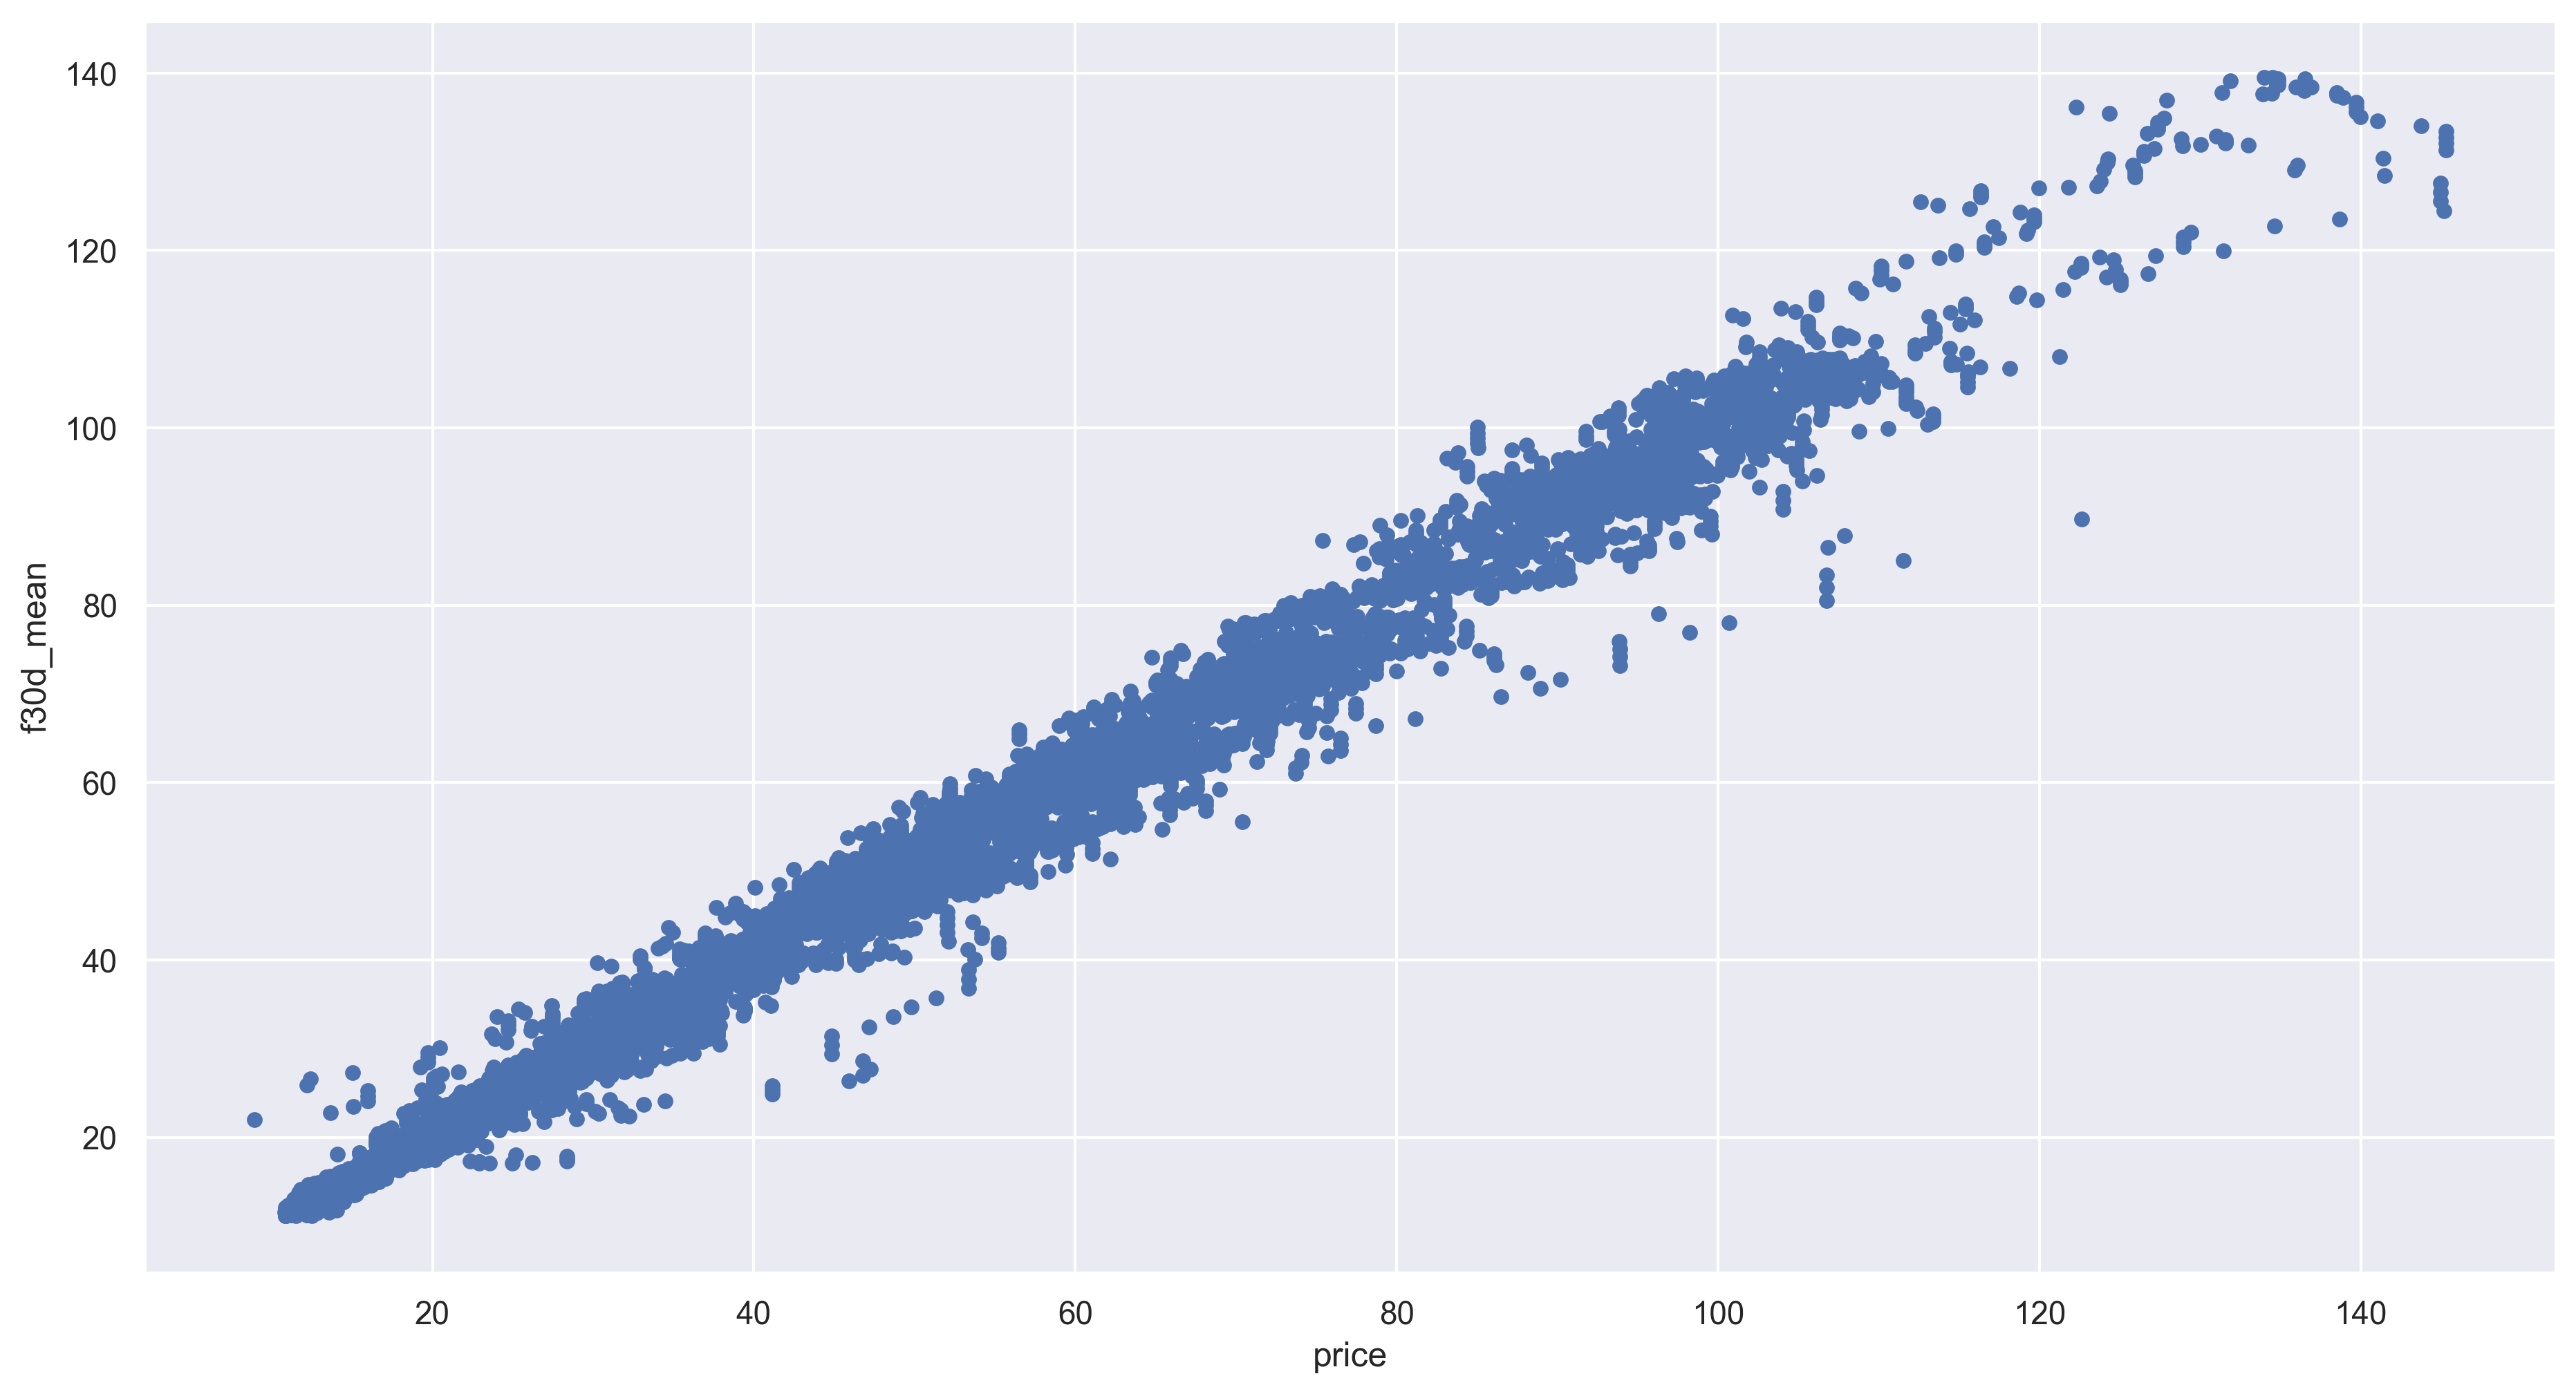

In [42]:
ts.plot.scatter(x='price', y='f30d_mean')

In [46]:
model_mse, model_mae = mse(y_test, predictions), mae(y_test, predictions)
model_mse, model_mae

(1.338829873475629, 0.8316907815360219)

In [48]:
X_test_price = pd.DataFrame(scal.inverse_transform(X_test))[0]

base_mse, base_mae = mse(y_test, X_test_price), mae(y_test, X_test_price)
base_mse, base_mae

(9.283846522483735, 2.0102813815537695)

In [49]:
test_df = pd.DataFrame(scal.inverse_transform(X_test), columns=X.columns)
test_df['prediction'] = predictions
test_df['actual'] = y_test.values
test_df['pred_error'] = test_df['prediction'] - test_df['actual']
test_df['assume_const_error'] = test_df['price'] - test_df['actual']
test_df['price_dev'] = test_df['actual'] - test_df['price']

test_df

price  t90d_mean  US Production    storage           gdp  f30d_mean_gdp  \
0     72.73  68.121111         5097.0  1019032.0  15290.309044   15285.476021   
1     58.08  60.269889         4891.0   991640.0  15176.228803   15211.071311   
2     99.40  91.120556         5862.0  1007644.0  16114.012206   16134.914718   
3     24.79  24.912333         6000.0   844791.0  12901.111502   12918.795512   
4     18.70  19.340556         6626.0   901770.0  10598.506533   10615.182911   
...     ...        ...            ...        ...           ...            ...   
3479  48.34  41.338556        11000.0  1138182.0  18905.572264   18953.715989   
3480  44.08  61.377667         9213.0  1064097.0  17276.663822   17296.256117   
3481  48.41  42.816667         5087.0   923487.0  14539.486441   14563.228431   
3482  51.46  66.888667        11700.0  1101049.0  18743.264074   18761.291129   
3483  20.57  17.749222         7130.0   959271.0   9408.158620    9399.902434   

      f365d_mean_gdp  prediction     actual  pred_error  assume_const_error  \
0       15437.406662   72.860390  71.212333    1.648056            1.517667   
1       15321.344079   61.691563  63.413000   -1.721437           -5.333000   
2       16250.119993   99.902832  98.813000    1.089832            0.587000   
3       13158.328086   26.200262  27.979667   -1.779405           -3.189667   
4       10784.200038   18.223280  18.701667   -0.478387           -0.001667   
...              ...         ...        ...         ...                 ...   
3479    19379.471574   49.522667  49.547667   -0.025000           -1.207667   
3480    17424.585248   50.021809  50.134333   -0.112525           -6.054333   
3481    14798.992306   52.181419  51.819667    0.361753           -3.409667   
3482    19009.098665   50.137989  50.064333    0.073656            1.395667   
3483     9333.514260   25.641531  27.135667   -1.494136           -6.565667   

      price_dev  
0     -1.517667  
1      5.333000  
2     -0.587000  
3      3.189667  
4      0.001667  
...         ...  
3479   1.207667  
3480   6.054333  
3481   3.409667  
3482  -1.395667  
3483   6.565667  

[3484 rows x 12 columns]

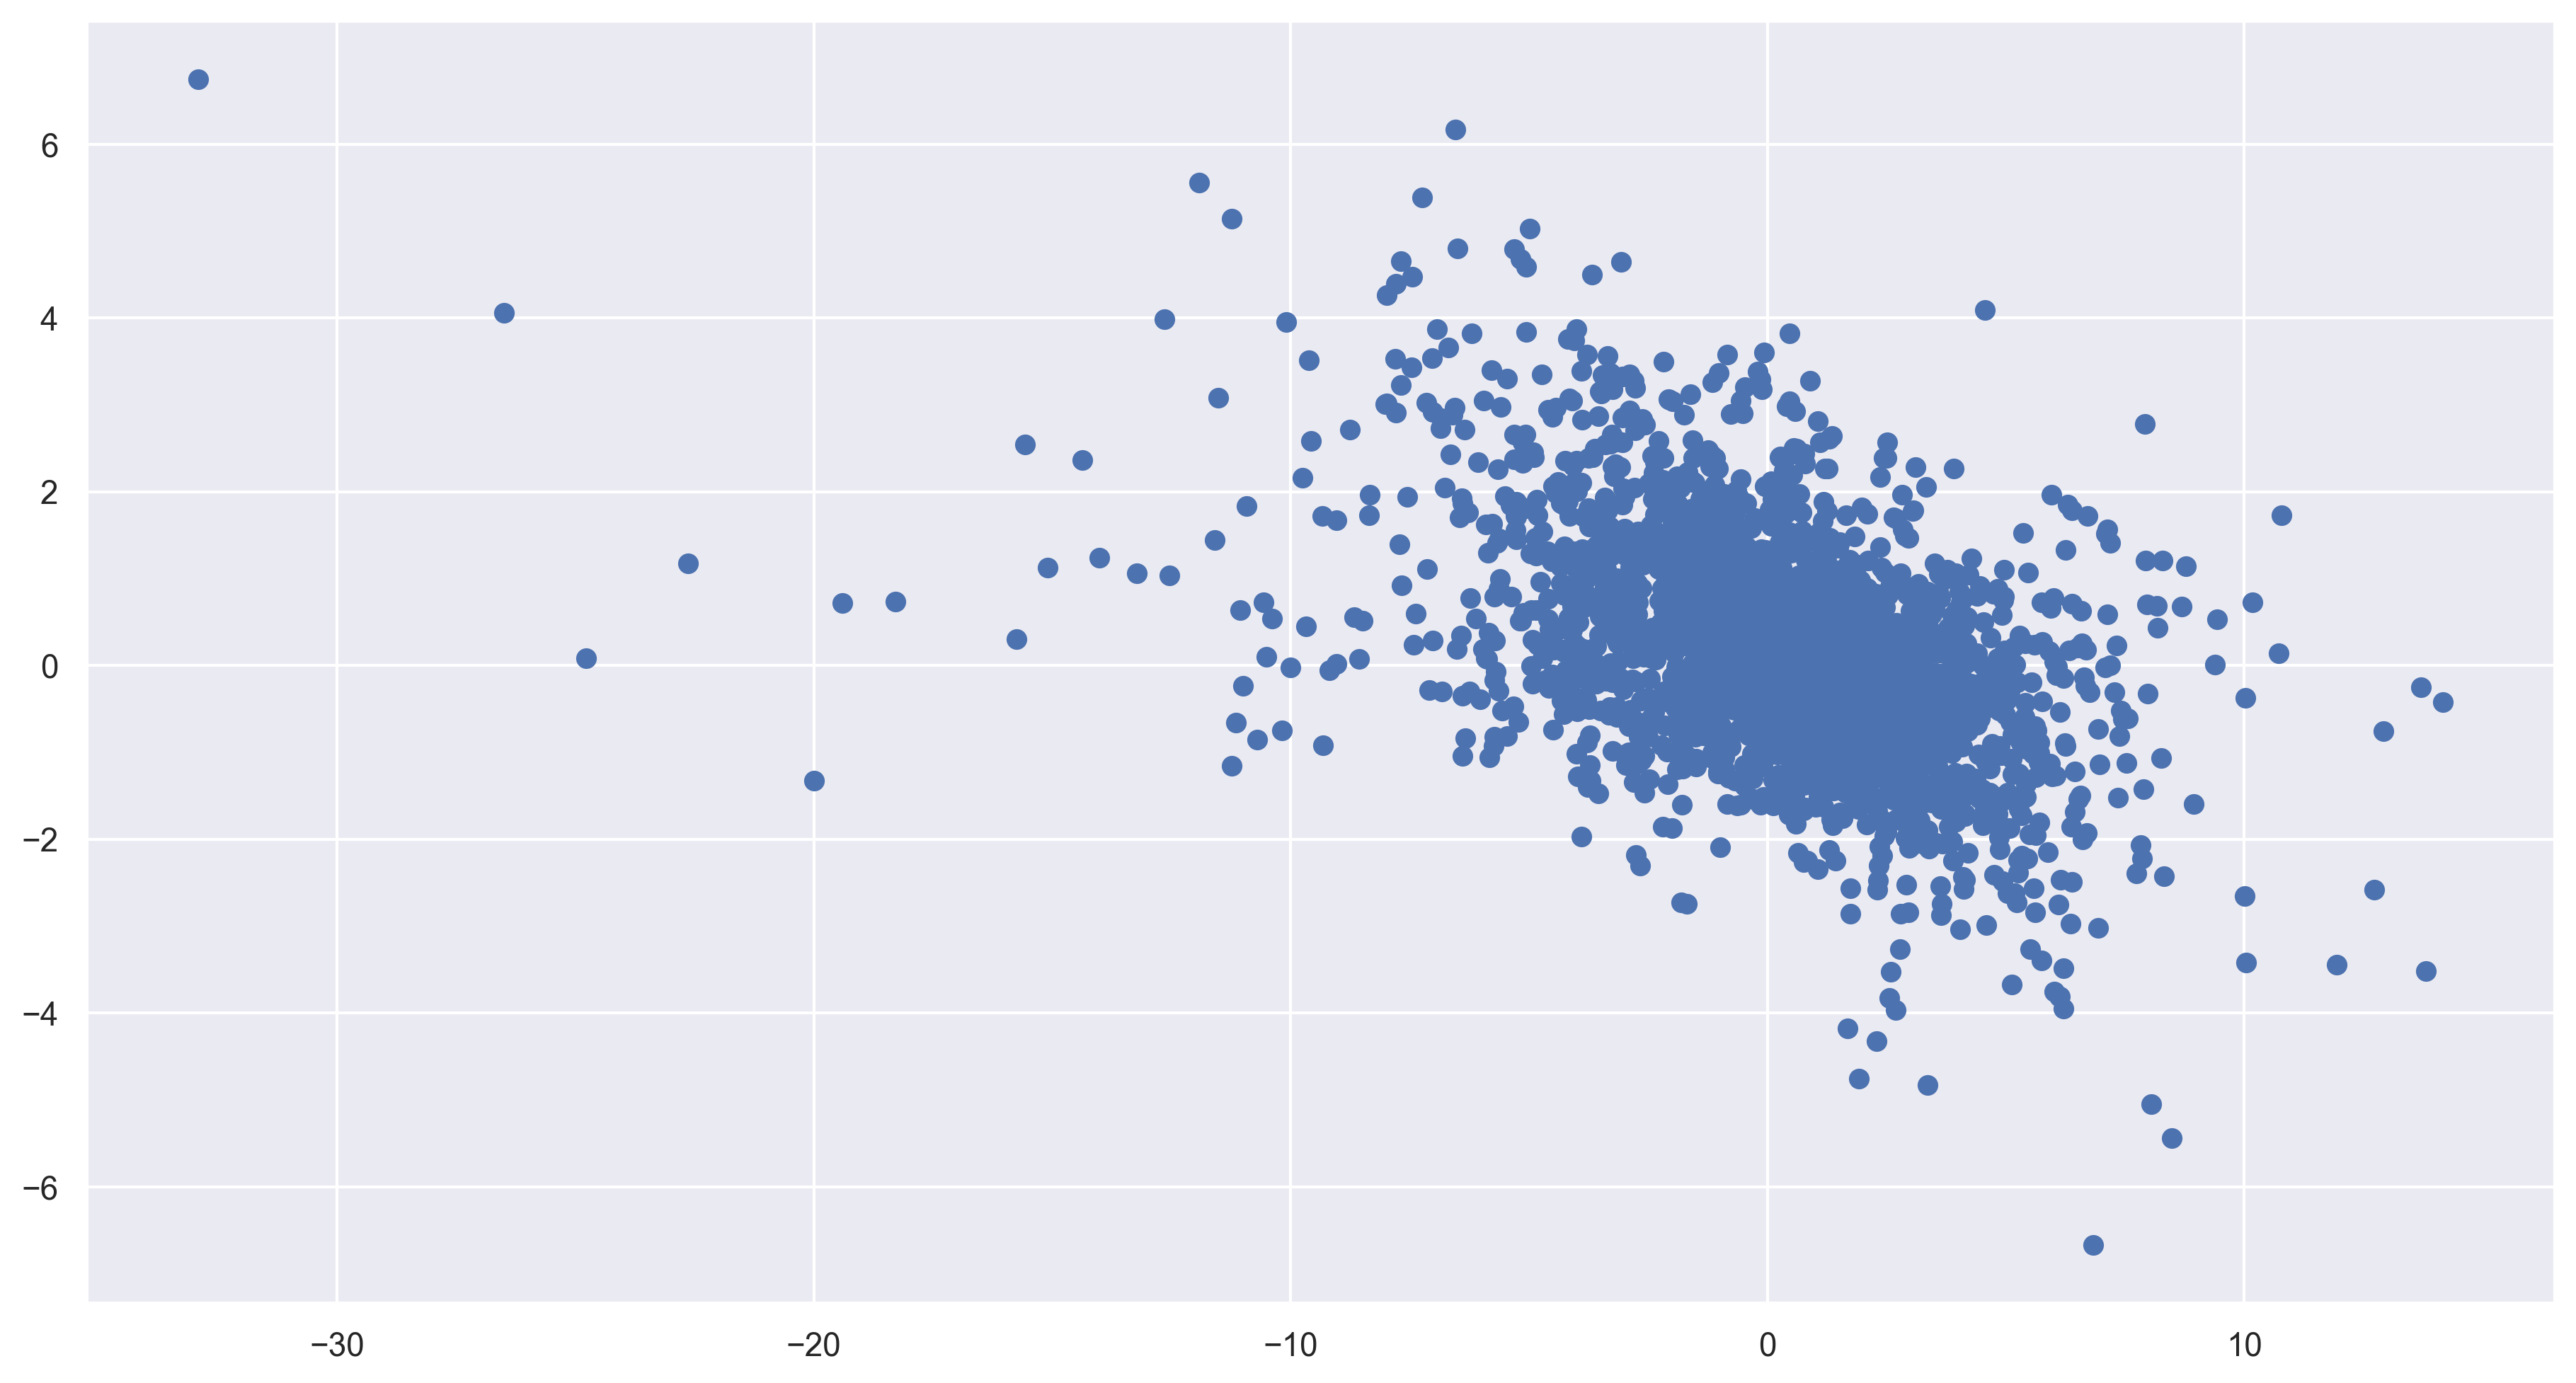

In [50]:
plt.scatter(test_df['price_dev'], test_df['pred_error'])